In [2]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import os
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath
import glob
import torch

from   torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from   torch.optim import Adam, SGD
from   torch.autograd import Variable
from   tqdm import tqdm
from   scipy.io import loadmat
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.metrics import confusion_matrix
from   scipy import signal
from   sklearn.decomposition import PCA
from   scipy.signal import butter,filtfilt
from   PIL import Image

In [4]:
import multiprocessing as mp

def worker_function(x):
    return x * x

if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)  # Use "spawn" method
    pool = mp.Pool(8)  # Create a pool of 8 processes
    
    # Example usage
    results = pool.map(worker_function, range(10))
    
    pool.close()
    pool.join()
    
    print(results)

In [3]:
###########################
# LP Noise Reduction Filter 
###########################

T = 1.0         # Sample Period
fs = 10.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y   

In [4]:
####################################
# Default parameters for readCSI_KIT 
####################################
test_env = 'ITIV'

NS     = 5     # Number of Sensors 261 configuration 4.feb.23 GDH
N10s   = 120   # 74  26x640 images 262 4 Fev 2023
iNiter = 0
Niter  = 9     # 9 iterations for training and 2 ex. for testing available 
NFrames= 12     

trainD = True   # train Data / test Data
wPCA   = False  # with PCA data reduction 264 -> 34
showIm = True   
wFilter= False  # median Outlyer and 3rd O. Butterworth noise reduciton filter
oAbs   = False   # only Absolute values (no Phase)
wEmptyFrames = False

#if trainD==True: NFrames=47; Niter=18   # 4 Train experiments with 47 frames each                 
if trainD==True: NFrames=12; Niter=9   # 4 Train experiments with 47 frames each                 
else: NFrames=27; Niter=1              # 1 Test  experiment  with 40 frames 

In [5]:
####################################################
#   read_csiKIT - BUILD ML data from .csv files
# trainD: True (training data), False (test data)
# wPCA = True  -> with PCA -> abPCA(34,34)
#        False -> abPCA(34,624), for img visualization
# showIm = True -> show (imgI, imR, ab, abPCA)  
# Niter = number of .csv files readed (max. 9)  
# wFilter = median (for outlyers) and LP (for noise)
# oAbs = only Abs (no Phase) - (17x34) Images   
# 
# trainx - CSI frames 
# trainy - frame labels 
# imgI, imgR - Img and Real CSI matrices (17x264)
# ab, abPCA  - Abs/Phase (34x624), PCA compr.(34x34)
####################################################
from   sklearn.decomposition import PCA
def read_csiKIT (trainD, wPCA, showIm, Niter, wFilter, oAbs):

    trainy=[]
    trainx=[]
    emptyTime=[] #np.array([])
    nearest = 200
    
    for ex in range(iNiter,Niter):
        print('experiment ex:',ex)
        
        # considering 6 sensors in S261. For 2 sensors S221 -> NS = 2
        if NS == 5:
            if trainD:                 # Train data from one environm GDH 1a 
                if ex==0: file_in = 'allactivity_person1_1.csv'    #  261 GDH        S3
                if ex==1: file_in = 'allactivity_person1_2.csv'    # 
                if ex==2: file_in = 'allactivity_person2_1_hor.csv'    # 
                if ex==3: file_in = 'allactivity_person2_1.csv'    #
                if ex==4: file_in = 'allactivity_person3_1.csv'    #   
                 
            else:                      # Test data from diff. environ/loc/person
                if test_env=='ITIV':     # 'ex<3' allow reuse of test data
                    if ex<3: file_in = 'allactivity_person2_1.csv'    
                if test_env=='ITIV':
                    if ex<3: file_in = 'allactivity_person3_1.csv'
                
                
    
        
                
        file_in = 'C://Users//Admin//OneDrive//Desktop//Thesis work//Data_Acquisition//after insert&delete/'+file_in   # 'f' - fixed CSI files by inserting lines to match sequence pattern
        
        if oAbs: pca = PCA(n_components = 10)   # only Abs
        else:    pca = PCA(n_components = 21)   # Abs & Phase
    
        t = []
        y = []
        yv= []
        ya= []
        carrier = []
        bords=[]
        nImg=1

        with open(file_in,'r') as csvfile:
            lines = csv.reader(csvfile, delimiter=',')
            for row in lines:
                t.append(float(row[13]))
                y.append(row[16])

        if showIm:
            fig, axs = plt.subplots(round(NFrames/6),6)
            fig.suptitle(file_in+'CSI Amplitude (21 x 540) :> 540 subcarriers = 5 sensors*(108 -4 pilots)')
            plt.axis('off')
            fig.set_figwidth(10)
            fig.set_figheight(10)

            fg, ax = plt.subplots(round(NFrames/6),6)
            fg.suptitle('CSI PCA (21 x 21) -> PCA 34 components')
            plt.axis('off')
            fg.set_figwidth(10)
            fg.set_figheight(10)

        ######################################
        # find 10 sec borders
        ######################################
        
        for idx, val in enumerate(t):
            searchV = nImg*10000.
            if searchV -val < nearest:      # approximating the border
                nearest = searchV - val 
                bord=[idx, val]
            if nearest <= 0:                # getting away from th border
                bords.append(bord)          # Register the border (last nearest)
                nImg+=1
                nearest = t[idx+2]
                
        bords=np.array(bords)
        
        ######################################
        # join CSI lines from the last border, until 10 seconds frame is complete
        for k in range (min(NFrames, len(bords))):            # Total 10 seconds frames
            CSi = []
            CSr = []
            var = []
        
            if k == 0: ini = 0
            else : ini = int(bords[k-1,0])
            print("Array size:", len(bords))
            print("Current index (k):", k)
            pas = int(bords[k,0])
            #pas = int(bords[k,0])

            if k < 45:
                npas= int(bords[k,0])
            
            ######################################
            # while t(n) in next 10s window
            # print('ini,pas',ini,pas,pas-ini)
            for j in range (ini, ini+N10s, NS):         # One 10 seconds Frame
                cvv=[]
                for i in range(NS):            
                    cvv.append([float(item) for item in y[i+j][1:-1].split(',')]) 

                cv=np.array(cvv)
                cv=cv.flatten()            # 1080 CSI values => 1 line of CSI image

                ci=cv[0:len(cv):2]         # Frame Size = [N10s/Ns,(216/2 Im,Re || Amp,Pha)*NS]
                cr=cv[1:len(cv):2]

                #if NS ==2:
                    #idxRm = [26, 53, 80, 107, 134, 161, 188, 215]     # Remove zeroes
                NS == 5
                idxRm = [ 26,  53,  80, 107, 134, 161, 188, 215, 242, 269, 296, 323, 350, 377, 404, 431, 458, 485, 512, 539]
     
                for m in sorted (idxRm, reverse=True):
                    ci=np.delete(ci,m)
                    cr=np.delete(cr,m)
                
                CSi.append(ci)
                CSr.append(cr)

            emptyTime=np.append(emptyTime,t[pas]-t[j])
            
            imgI = np.array(CSi,dtype=float)
            imgR = np.array(CSr,dtype=float)

            #aa=np.array(imgI)
            #ap=np.array(imgR)
            li,co = imgI.shape
            
            if oAbs: rang=li
            else: rang=2*li
            
            if oAbs:
                ab=np.zeros((li,co)) # both: Amp & Phase
                for i in range(li):
                    for c in range(co):
                        ab[i][c]=abs(complex(imgI[i,c],imgR[i,c]))
            else:
                ab=np.zeros((2*li,co)) # both: Amp & Phase
                for i in range(li):
                    for c in range(co):
                        ab[i][c]=abs(complex(imgI[i,c],imgR[i,c]))
                        ab[i+li][c]=cmath.phase(complex(imgI[i,c],imgR[i,c]))
                    
            
    ######################################
    # median Filter - catch outlyers in each line
    ######################################                   
    ######################################
            #print('wFilter',wFilter)
            if wFilter:
                for i in range(rang):
                    ab[i] = signal.medfilt(ab[i])    
                
    ######################################
    # Sanitize Phase 
    ######################################                   
    ######################################
            if oAbs == False:
                for i in range(li):
                    for c in range(co-1):
                        delta = ab[i+li][c+1]-ab[i+li][c]
                        if delta > 3.1415926:
                            ab[i+li][c+1]=ab[i+li][c]+delta-2*3.1415926
                        if delta < -3.1415926:
                            ab[i+li][c+1]=ab[i+li][c]+delta+2*3.1415926
            
    ######################################
    # Low Pass - reduce noise 
    ######################################                   
    ######################################
            if wFilter:
                for i in range(rang):
                    ab[i] = butter_lowpass_filter(ab[i],cutoff,fs,3)      
                
        #    print("shape cv",cv.shape,"shape imgI",imgI.shape)

        #    k - corresponds to (50, 33, 10) cycles for NS = (1,2,6)
        #    
        #    sit    stand   walk   stand    sit    stand   walk  stand  sit
        # k: 0      3       6      9        12     15      18    21     24   27   

    # 23.Jan.2023
    #    sit stand walk empty empty walk stand sit stand walk empty empty walk stand sit
    # k: 0   3     6    9     12    15   18    21  24    27   30    33    36   39    42
            
            if k in range(0,2) or k in range (21,23) or k in range (42,50): ttxt='sit'
            if k in range(3,5) or k in range (18,19) or k in range (24,26) or k in range (39,41): ttxt='stand'
            if k in range(6,8) or k in range (15,17) or k in range (27,29) or k in range (36,38): ttxt='walk'
            if k in range(9,14) or k in range (30,35): ttxt='empty'

            #print('showIm k:',k)
            if showIm:
                axs[k//6,k%6].imshow(ab, interpolation='nearest',aspect='auto')   
                axs[k//6,k%6].axis('off')
                axs[k//6,k%6].title.set_text(ttxt)

            #ab=np.transpose(aa)
            #print(wPCA)
            if wPCA:
                abPCA = pca.fit_transform(ab)
                print('pca.explained_variance_ratio_',pca.explained_variance_ratio_)
                print('pca.singular_values_',pca.singular_values_)
            else:
                abPCA = ab
            
            if showIm:
                ax[k//6,k%6].imshow(abPCA, interpolation='nearest',aspect='auto')   
                ax[k//6,k%6].axis('off')
                ax[k//6,k%6].title.set_text(ttxt)

            trainy.append(ttxt)
            trainx.append(abPCA)        
    
        emptyTime=emptyTime[:-1]
        

        #print('len(y)',len(y),'NS',NS,'N10s',N10s)
        #print('imgI',imgI.shape,'abPCA',abPCA.shape)
        #print('aa',aa.shape)
        # 1207601     

        #print("t(min):",277558.933/1000/60, "Lines per frame:",4201/N10s/NS)

        #print(trainy)
        #print(len(trainx),len(trainx[0]),len(trainx[0][0]))
    
    if wEmptyFrames:
        plt.figure()
        plt.plot(emptyTime[:-1]/1000,label='et')
        plt.title('Empty Time in Frames of '+file_in)
        plt.legend()
        plt.xlabel('Frames')
        plt.ylabel('s')
        plt.show()
        
    return trainx, trainy, imgI, imgR, ab, abPCA

In [6]:
import numpy as np
zo=[26, 53, 80, 107]
zr=np.zeros(4*5)
#, 134, 161, 188, 215]
for s in range(5):
    for i in range (4):
        zr[4*s+i] = zo[i]+27*4*s
print(zr)

[ 26.  53.  80. 107. 134. 161. 188. 215. 242. 269. 296. 323. 350. 377.
 404. 431. 458. 485. 512. 539.]


In [7]:
def plotModPha():
    # NS=2 -> 208 x 208 = 104 abs + 104 phas
    NS=5
    hN10s=int(21/2)

    print(hN10s,N10s)

    ph_li = np.squeeze(trainx[0,0,hN10s,:])
    #print(ph_li)
    print(ph_li.shape)
    i=10
    f=15
    fi=2
    tit = 'PCA CSI || & /_  ===> i='+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)
    #plt.plot(np.transpose(trainx[0,0,104:108,4:108]))
    #plt.show()

    fig, axs = plt.subplots(2,2)
    fig.suptitle(tit)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    csi0=np.transpose(trainx[fi,0,i:f,0:104])
    print('csi0:',csi0.shape)
    
    axs[0,0].plot(np.transpose(trainx[fi,0,i:f,0:104]))                         
    axs[0,0].set_title('|S3| from M1, from M2')
    axs[0,0].legend(['i', 'i+1', 'i+2','i+3','i+4'])
    axs[0,1].plot(np.transpose(trainx[fi,0,i:f,104:208]))                           
    axs[0,1].set_title('|S4| from M1, from M2')
    axs[0,1].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[1,0].plot(np.transpose(trainx[fi,0,i+17:f+17,0:104]))                           
    axs[1,0].set_title('/S3| from M1, from M2')
    axs[1,0].legend(['i', 'i+1', 'i+2','i+3','i+4'])
    axs[1,1].plot(np.transpose(trainx[fi,0,i+17:f+17,104:208]))                           
    axs[1,1].set_title('/S4| from M1, from M2')
    axs[1,1].legend(['i', 'i+1', 'i+2','i+3','i+4'])

In [8]:
def plotSigCSI_S3_S9():
    fr=52  # 208/4 

    #ph_li = np.squeeze(trainx[0,0,34,:])
    #print(ph_li)
    #print(ph_li.shape)
    i=10
    f=15
    fi=46
    tit = 'PCA CSI || & sanit.(/_) Median 10 Hz Butterw. i='+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)
    #plt.plot(np.transpose(trainx[0,0,104:108,4:108]))
    #plt.show()

    fig, axs = plt.subplots(2,4)
    fig.suptitle(tit)
    fig.set_figwidth(10)
    fig.set_figheight(10)


    axs[0,0].plot(np.transpose(trainx[fi,0,i:f,0:fr]))                           
    axs[0,0].set_title('|S3| from M1')
    axs[0,0].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[0,1].plot(np.transpose(trainx[fi,0,i:f,fr:2*fr]))                           
    axs[0,1].set_title('|S3| from M2')
    axs[0,1].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[0,2].plot(np.transpose(trainx[fi,0,i:f,2*fr:3*fr]))                           
    axs[0,2].set_title('|S4| from M1')
    axs[0,2].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[0,3].plot(np.transpose(trainx[fi,0,i:f,3*fr:4*fr]))                           
    axs[0,3].set_title('|S4| from M2')
    axs[0,3].legend(['i', 'i+1', 'i+2','i+3','i+4'])


    axs[1,0].plot(np.transpose(trainx[fi,0,i+17:f+2*fr,0:fr]))                           
    axs[1,0].set_title('/S3| from M1')
    axs[1,0].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[1,1].plot(np.transpose(trainx[fi,0,i+17:f+2*fr,fr:2*fr]))                           
    axs[1,1].set_title('/S3| from M2')
    axs[1,1].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[1,2].plot(np.transpose(trainx[fi,0,i+17:f+2*fr,2*fr:3*fr]))                           
    axs[1,2].set_title('/S4| from M1')
    axs[1,2].legend(['i', 'i+1', 'i+2','i+3','i+4'])

    axs[1,3].plot(np.transpose(trainx[fi,0,i+17:f+2*fr,3*fr:4*fr]))                           
    axs[1,3].set_title('/S4| from M2')
    axs[1,3].legend(['i', 'i+1', 'i+2','i+3','i+4'])

In [9]:
def plotModPhaCarr6Sens():
    # Plot consecutive signals from the same link (M1->S3)[0:n] 
    fr=52   # 208/4 
    print(trainx.shape)
    se = ['3','4','5','6','7']
    i=10
    NFrames = 47
    f=15
    nv=3 # 5 frames
    fi = 10  # Initial Frame to show, used S3<-M1 S3<-M2, S9<-M1 S9<-M2 ... 

    idxRm = [ 26,  53,  80, 107, 134, 161, 188, 215, 242, 269, 296, 323, 350, 377, 404, 431, 458, 485, 512, 539,]
        
    for n in range(5):
            
        abs31=np.array([])
        pha31=np.array([])
        abs32=np.array([])
        pha32=np.array([])

    #    for i in range(nv):
    #        abs31 = np.append(abs31, trainx[fi+i,0,0:17,n*54+f])
    #        pha31 = np.append(pha31, trainx[fi+i,0,17:34,n*54+f])
    #        abs32 = np.append(abs32, trainx[fi+i,0,0:17,(n+1)*54+f])
    #        pha32 = np.append(pha32, trainx[fi+i,0,17:34,(n+1)*54+f])
        for i in range(nv): 
            abs31 = np.append(abs31, trainx[fi+i,0,0,n*52:(n+1)*52])
            pha31 = np.append(pha31, trainx[fi+i,0,17,n*52:(n+1)*52])
            abs32 = np.append(abs32, trainx[fi+i,0,0,(n+1)*52:(n+2)*52])
            pha32 = np.append(pha32, trainx[fi+i,0,17,(n+1)*52:(n+2)*52])

        print(abs31.shape)

        tit = 'Consecutive CSI || & sanit.(/_) Median 10 Hz Butterw. i='+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)

        fig, axs = plt.subplots(2,2)
        fig.suptitle(tit)
        fig.set_figwidth(12)
        fig.set_figheight(10)

        st='|S'+str(se[n])+'| from M'+str(1)
        axs[0,0].plot(np.transpose(abs31))  
        axs[0,0].plot([52, 52],[np.min(abs31), np.max(abs31)],color='r')   
        axs[0,0].plot([104, 104],[np.min(abs31), np.max(abs31)],color='r')                           
        axs[0,0].set_title(st)
        axs[0,0].legend(['i', 'i+1', 'i+2','i+3','i+4'])
        axs[0,0].plot(idxRm[0:6],np.zeros(6),'o')

        st='/S'+str(se[n])+'| from M'+str(1)
        axs[1,0].plot(np.transpose(pha31))                         
        axs[1,0].plot([52, 52],[np.min(pha31), np.max(pha31)],color='r')                           
        axs[1,0].plot([104, 104],[np.min(pha31), np.max(pha31)],color='r')                           
        axs[1,0].set_title(st)
        axs[1,0].legend(['i', 'i+1', 'i+2','i+3','i+4'])
        axs[1,0].plot(idxRm[0:6],np.zeros(6),'o')

        st='|S'+str(se[n])+'| from M'+str(2)
        axs[0,1].plot(np.transpose(abs32))                           
        axs[0,1].plot([52, 52],[np.min(abs32), np.max(abs32)],color='r')                           
        axs[0,1].plot([104, 104],[np.min(abs32), np.max(abs32)],color='r')                           
        axs[0,1].set_title(st)
        axs[0,1].legend(['i', 'i+1', 'i+2','i+3','i+4'])
        axs[0,1].plot(idxRm[0:6],np.zeros(6),'o')

        st='/S'+str(se[n])+'| from M'+str(2)
        axs[1,1].plot(np.transpose(pha32))                         
        axs[1,1].plot([52, 52],[np.min(pha32), np.max(pha32)],color='r')                           
        axs[1,1].plot([104, 104],[np.min(pha32), np.max(pha32)],color='r')                           
        axs[1,1].set_title(st)
        axs[1,1].legend(['i', 'i+1', 'i+2','i+3','i+4'])
        axs[1,1].plot(idxRm[0:6],np.zeros(6),'o')

In [10]:
def plotS3_5c_all_c(fi=12,ff=7):
    # Plot consecutive subcarriers - time domain signalslink (M1->S3)[0:n] 
    fr=50   # 208/4 
    print(trainx.shape)
    se = ['3','3','4','4','5','5','6','6','7','7']  # M1, M2
    har= ['sit','sit','sit','stand','stand','stand','walk','walk','walk','empty','empty','empty','empty','empty','empty',
        'walk','walk','walk','stand','stand','stand','sit','sit','sit']
    n =0      # n=1 -> S9

                # 108 * 6 = 648
                # - 8x zero removals =>  idxRm = [26, 53, 80, 107, 134, 161, 188, 215]     # Remove zeroes from Abs and from Phase
                #                                  1   1   2    2   3    3    4    4

    nv=5
    fi = 11  # ini Frame used S3<-M1 S3<-M2 
    ff = 9  # final Frame
    i=0
    f=5    #carrier freq. of interest  


    abs31=np.array([])
    pha31=np.array([])

    for ni in range(ff,fi-1,-1):     # 3 frames = 30 s            
        abs31 = np.append(abs31, trainx[fi+ni,0,  0:17, n*52:n*52+52])
        pha31 = np.append(pha31, trainx[fi+ni,0, 17:34, n*52:n*52+52])

    print('trainx',trainx.shape, 'abs31',abs31.shape)
    print(pha31.shape, ff*17,ff*17*52)

    abs31 = abs31.reshape(ff*17,52)
    pha31 = pha31.reshape(ff*21,52)

    print(abs31.shape)

    tit = 'Consecutive CSI subcarriers, Sensor:'+se[n]+' || '+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)

    fig, axs = plt.subplots(4,1)
    fig.suptitle(tit)
    fig.set_figwidth(20)
    fig.set_figheight(10)

    st='carriers ='+str(i)+':'+str(f)+' |S'+str(se[n])+'| from M'+str(1+n%2)
    axs[0].plot(abs31[:,i:f]) 
    for tr in range(ff):
        axs[0].plot([tr*17, tr*17],[5,20],color='r')
        axs[0].text(tr*17,19, har[tr], color='r')                           
    axs[0].set_title(st)
    axs[0].legend(['i', 'i+1', 'i+2','i+3','i+4'],loc="center right")

    st='carriers = 0:54, |S'+str(se[n])+'| from M'+str(1+n%2)
    axs[1].plot(abs31[:,0:54])                           
    for tr in range(ff):
        axs[1].plot([tr*17, tr*17],[5, 20],color='r')                           
    axs[1].set_title(st)

In [11]:
##################################
# plot carriers in the time-domain
# Plot consecutive subcarriers - time domain signalslink (M1->S3)[0:n] 

def plotS3_5c_parts(fi,ff,iniP=0):
    
    # fi - initial frame
    # ff - final frame

    fr=50   # 208/4 
    print(trainx.shape)
    se = ['3','3','4','4','5','5','6','6','7','7']  # M1, M2
    har= ['sit','sit','sit','stand','stand','stand','walk','walk','walk','empty','empty','empty','empty','empty','empty',
        'walk','walk','walk','stand','stand','stand','sit','sit','sit']
    n =0      # n=1 -> S9

                # 108 * 6 = 648
                # - 8x zero removals =>  idxRm = [26, 53, 80, 107, 134, 161, 188, 215]     # Remove zeroes from Abs and from Phase
                #                                  1   1   2    2   3    3    4    4

    nv=5
    #fi = 12  # ini Frame used S3<-M1 S3<-M2 
    #ff = 7  # final Frame
    i=5
    f=7    #carrier freq. of interest  


    abs31=np.array([])
    pha31=np.array([])

    for ni in range(ff):     # 3 frames = 30 s            
        abs31 = np.append(abs31, trainx[fi+ni,0,  0:17, n*52:n*52+52])
        pha31 = np.append(pha31, trainx[fi+ni,0, 17:34, n*52:n*52+52])

    print('trainx',trainx.shape, 'abs31',abs31.shape)
    print(pha31.shape, ff*17,ff*17*52)

    abs31 = abs31.reshape(ff*17,52)
    pha31 = pha31.reshape(ff*34,52)

    print(abs31.shape)

    tit = 'Consecutive CSI subcarriers, Sensor:'+se[n]+' || '+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)

    fig, axs = plt.subplots(2,1)
    fig.suptitle(tit)
    fig.set_figwidth(20)
    fig.set_figheight(15)

    st='carriers ='+str(i)+':'+str(f)+' |S'+str(se[n])+'| from M'+str(1+n%2)
    
    xvect = list(range(17*fi,17*(fi+ff)))
    print(abs31.shape, len(xvect))
    axs[0].plot(xvect,abs31[:,i:f],'--o') 
    for tr in range(ff):
        axs[0].plot([tr*17+int(xvect[0]), tr*17+int(xvect[0])],[5,20],color='r')
        axs[0].text(tr*17+int(xvect[0]),19, har[tr+iniP], color='r')                           
    axs[0].set_title(st)
    axs[0].legend(['i', 'i+1', 'i+2','i+3','i+4'],loc="center right")

    st='carriers = 0:54, |S'+str(se[n])+'| from M'+str(1+n%2)
    axs[1].plot(xvect,abs31[:,0:54],'--o')                           
    for tr in range(ff):
        axs[1].plot([tr*17+int(xvect[0]), tr*17+int(xvect[0])],[5, 20],color='r')                           
    axs[1].set_title(st)

In [12]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import os
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath
import glob
import torch

from   torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from   torch.optim import Adam, SGD
from   torch.autograd import Variable
from   tqdm import tqdm
from   scipy.io import loadmat
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.metrics import confusion_matrix
from   scipy import signal
from   sklearn.decomposition import PCA
from   scipy.signal import butter,filtfilt
from   PIL import Image


trainx, trainy, imgI, imgR, ab, abPCA = read_csiKIT(trainD=True,wPCA=False, showIm =False,Niter=1,wFilter=False,oAbs=False)
trainx = np.expand_dims(trainx, axis=1)
            
plotS3_5c_parts(fi=0,ff=12, iniP=0)
#plotS3_5c_parts(fi=12,ff=24, iniP=6)

#plotS3_5c_parts(fi=24,ff=36, iniP=0)
#plotS3_5c_parts(fi=36,ff=47, iniP=6)

experiment ex: 0
Array size: 13
Current index (k): 0
Array size: 13
Current index (k): 1
Array size: 13
Current index (k): 2
Array size: 13
Current index (k): 3
Array size: 13
Current index (k): 4
Array size: 13
Current index (k): 5
Array size: 13
Current index (k): 6
Array size: 13
Current index (k): 7
Array size: 13
Current index (k): 8
Array size: 13
Current index (k): 9
Array size: 13
Current index (k): 10
Array size: 13
Current index (k): 11
Array size: 13
Current index (k): 12
(13, 1, 60, 520)
trainx (13, 1, 60, 520) abs31 (10608,)
(10608,) 204 10608


ValueError: cannot reshape array of size 10608 into shape (408,52)

In [13]:
def plotHAR12Sensors():

    # Plot consecutive subcarriers - time domain signalslink (M1->S3)[0:n] 
    fr=52   # 208/4 
    print(trainx.shape)
    se = ['3','3','4','4','5','5','6','6','7','7']  # M1, M2
    har= ['sit','sit','sit','stand','stand','stand','walk','walk','walk','empty','empty','empty','empty','empty','empty',
        'walk','walk','walk','stand','stand','stand','sit','sit','sit','stand','stand','stand','walk','walk','walk','empty','empty','empty','empty','empty','empty',
        'walk','walk','walk','stand','stand','stand','sit','sit','sit','sit','sit','sit']
   
        # n=1 -> S9

                # 108 * 6 = 648
                # - 8x zero removals =>  idxRm = [26, 53, 80, 107, 134, 161, 188, 215]     # Remove zeroes from Abs and from Phase
                #                                  1   1   2    2   3    3    4    4

    fig, axs = plt.subplots(12,1)
    fig.set_figwidth(20)
    fig.set_figheight(40)

    fg, ax = plt.subplots(12,1)
    fg.set_figwidth(20)
    fg.set_figheight(40)

    nv=5
    fi = 0     # ini Frame used S3<-M1 S3<-M2 
    ff = 42*5  # 42 frames per experiments x 6 experiments!!!!
    ff = 24
    i=10
    f=12       #carrier freq. of interest  

    for n in range(12):
        abs31=np.array([])
        pha31=np.array([])

        tit = 'Consecutive CSI subcarriers, Sensor:'+se[n]+' || '+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)
        tit = 'Consecutive CSI subcarriers, Sensor:'+se[n]+' /| '+str(i)+' f='+str(f)+' Init.Frame fi='+str(fi)
   
        for ni in range(ff):     # 3 frames = 30 s            
            abs31 = np.append(abs31, trainx[fi+ni,0,  0:17, n*52:n*52+52])
            pha31 = np.append(pha31, trainx[fi+ni,0, 17:34, n*52:n*52+52])

        print('trainx',trainx.shape, 'abs31',abs31.shape)
        print(pha31.shape, ff*17,ff*17*52)

        abs31 = abs31.reshape(ff*17,52)
        pha31 = pha31.reshape(ff*17,52)
        
        for j in range(52):        # Remove 'Outlyers' in the time-domain
            abs31[:,j] = signal.medfilt(abs31[:,j])   
            pha31[:,j] = signal.medfilt(pha31[:,j])   
            abs31[:,j] = butter_lowpass_filter(abs31[:,j],2*cutoff,fs,3)      
            pha31[:,j] = butter_lowpass_filter(pha31[:,j],2*cutoff,fs,3)      
        
        st='carriers ='+str(i)+':'+str(f)+' |S'+str(se[n])+'| from M'+str(1+n%2)
        fp = ff
        for tr in range(0,fp,3):
            mean3 = np.mean(abs31[tr*17:(tr+3)*17,i:f])
            var3  = np.var(abs31[tr*17:(tr+3)*17,i:f])
            axs[n].plot([tr*17, (tr+3)*17],[mean3, mean3],color='b')
            axs[n].plot([tr*17, (tr+3)*17],[var3, var3],color='c')
        axs[n].plot(abs31[:,i:f])                                       
        for tr in range(fp):
            axs[n].plot([tr*17, tr*17],[5,20],color='r')
            axs[n].text(tr*17,19, har[tr], color='r') 
        axs[n].legend(['mean','var','i', 'i+1', 'i+2','i+3','i+4'])
        axs[n].set_title(st)
     
        st='carriers ='+str(i)+':'+str(f)+' /S'+str(se[n])+'| from M'+str(1+n%2)
        for tr in range(0,fp,3):
            mean3 = np.mean(pha31[tr*17:(tr+3)*17,i:f])
            var3  = np.var(pha31[tr*17:(tr+3)*17,i:f])
            ax[n].plot([tr*17, (tr+3)*17],[mean3, mean3],color='b')
            ax[n].plot([tr*17, (tr+3)*17],[var3, var3],color='c')
        ax[n].plot(pha31[:,i:f])                                                 
        for tr in range(fp):
            ax[n].plot([tr*17, tr*17],[np.min(pha31), np.max(pha31)],color='r') 
            ax[n].text(tr*17,19, har[tr], color='r')  
        ax[n].legend(['mean','var','i', 'i+1', 'i+2','i+3','i+4'])
        ax[n].set_title(st)
    
    print('abs31.shape:',abs31.shape, 'pha31.shape',pha31.shape)   
    trainxx=np.array([])
    trainxx = np.append(trainxx,abs31)
    trainxx = np.append(trainxx,pha31)
    
    # 445536
    #trainxx = np.reshape(trainxx,(4284,104)) # 52 Abs carriers and 52 Phase carriers
    print('trainxx.shape',trainxx.shape)   
    return trainxx

In [14]:
print(trainy)
trainy=np.array(trainy)
print(trainy)

for i in range(trainy.shape[0]):
    if trainy[i]=='sit':
        trainy[i] = 0
    elif trainy[i]=='stand':
        trainy[i] = 1
    elif trainy[i] == 'walk':
        trainy[i] = 2
    elif trainy[i] == 'empty':
        trainy[i] = 3
    else:
        trainy[i] = 4

['sit', 'sit', 'sit', 'stand', 'stand', 'stand', 'walk', 'walk', 'walk', 'empty', 'empty', 'empty', 'empty']
['sit' 'sit' 'sit' 'stand' 'stand' 'stand' 'walk' 'walk' 'walk' 'empty'
 'empty' 'empty' 'empty']


experiment ex: 0
Array size: 13
Current index (k): 0
Array size: 13
Current index (k): 1
Array size: 13
Current index (k): 2
Array size: 13
Current index (k): 3
Array size: 13
Current index (k): 4
Array size: 13
Current index (k): 5
Array size: 13
Current index (k): 6
Array size: 13
Current index (k): 7
Array size: 13
Current index (k): 8
Array size: 13
Current index (k): 9
Array size: 13
Current index (k): 10
Array size: 13
Current index (k): 11
Array size: 13
Current index (k): 12
(13, 1, 60, 520)
10 150
(520,)
csi0: (104, 5)


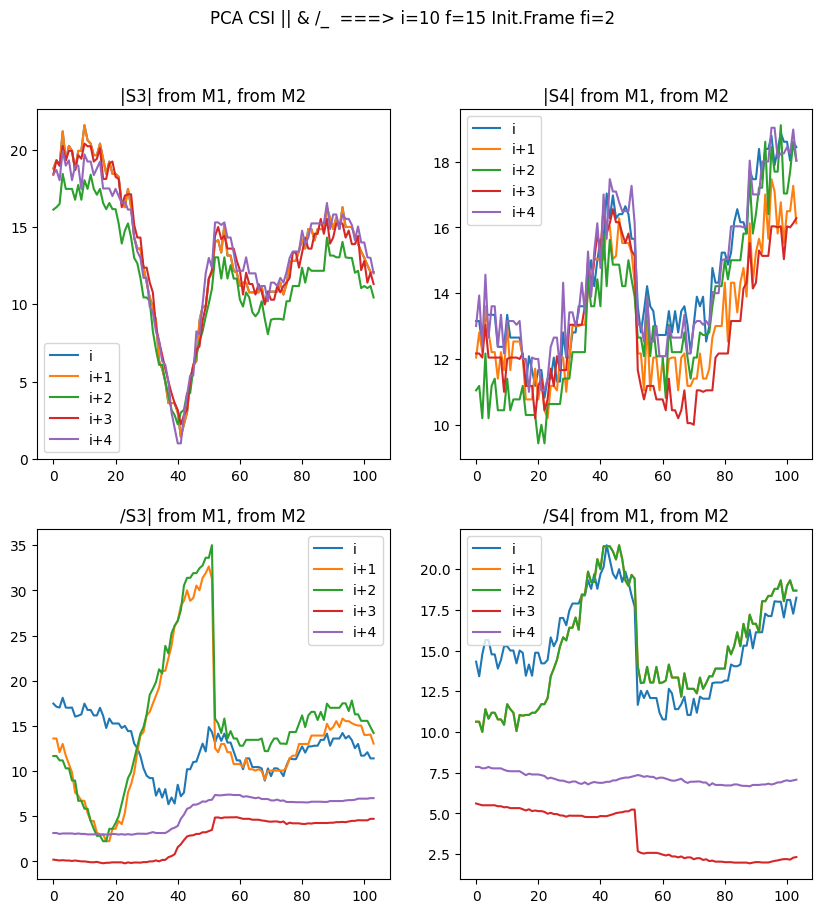

In [15]:
################################
# LOAD DATA
################################

trainx, trainy, imgI, imgR, ab, abPCA = read_csiKIT(trainD=True,wPCA=False, showIm =False,Niter=1,wFilter=False,oAbs=False)

trainx = np.expand_dims(trainx, axis=1)
print(trainx.shape)


###############################################
# CALL PLOT FUNCTIONS - INDIVIDUAL Code Cells -
###############################################

plotModPha()

IndexError: index 46 is out of bounds for axis 0 with size 13

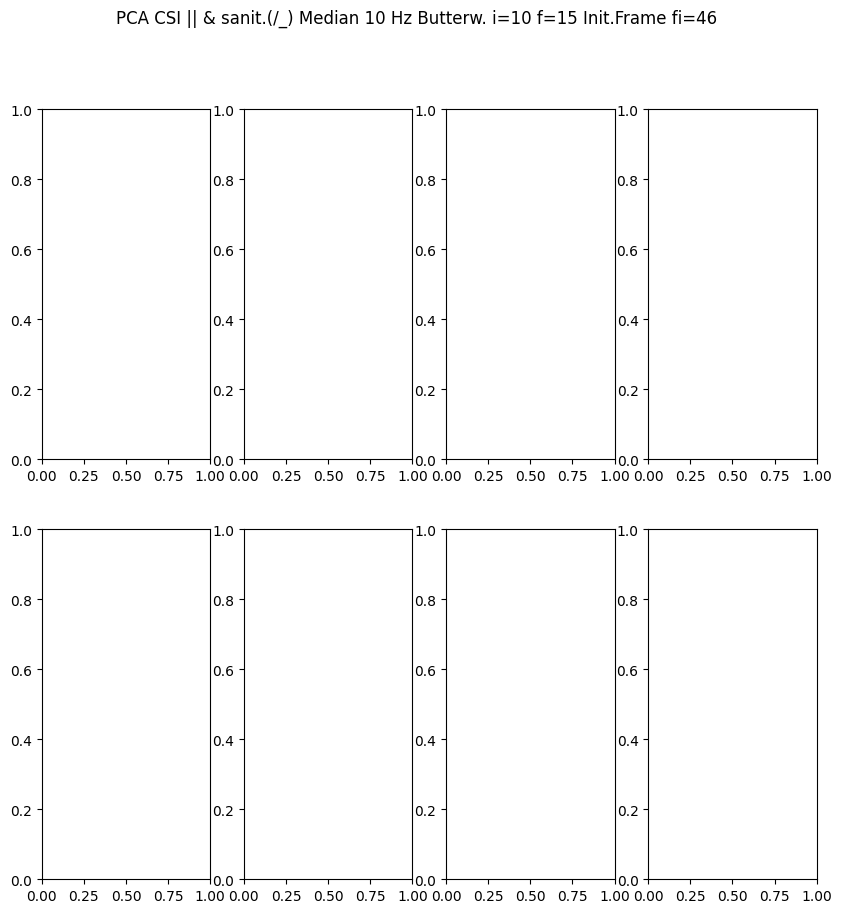

In [16]:
plotSigCSI_S3_S9()

(13, 1, 60, 520)
(156,)
(156,)
(156,)
(156,)
(156,)


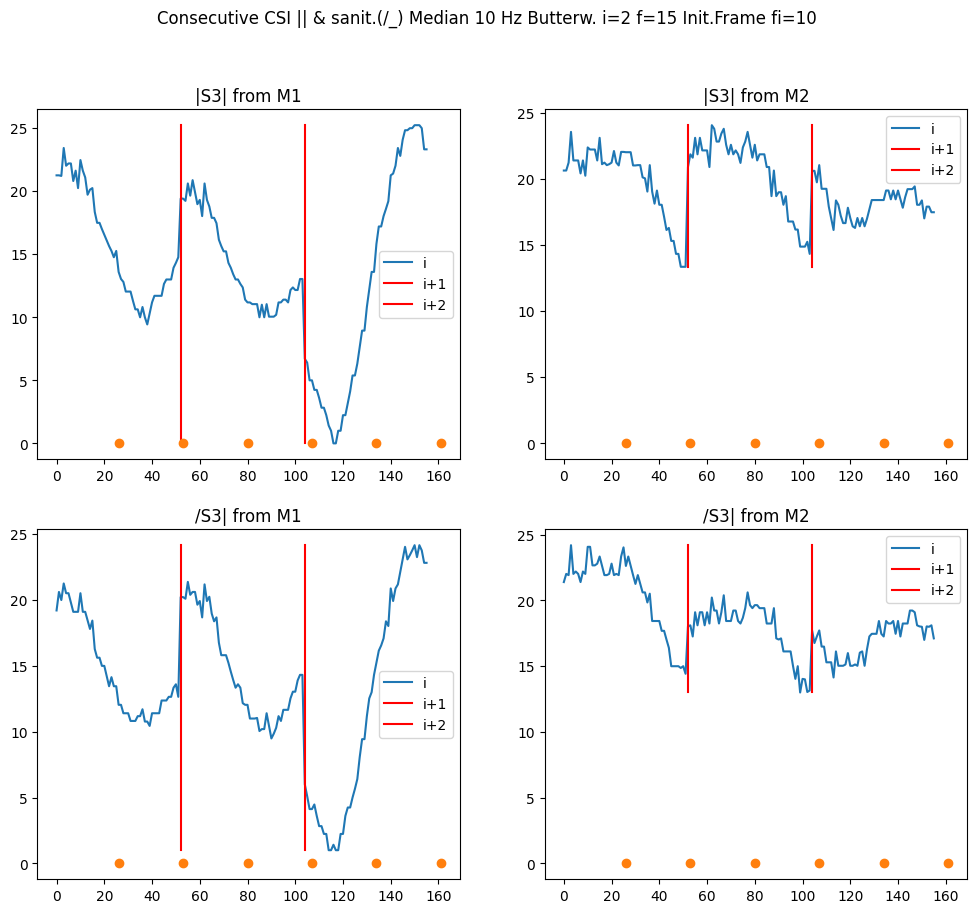

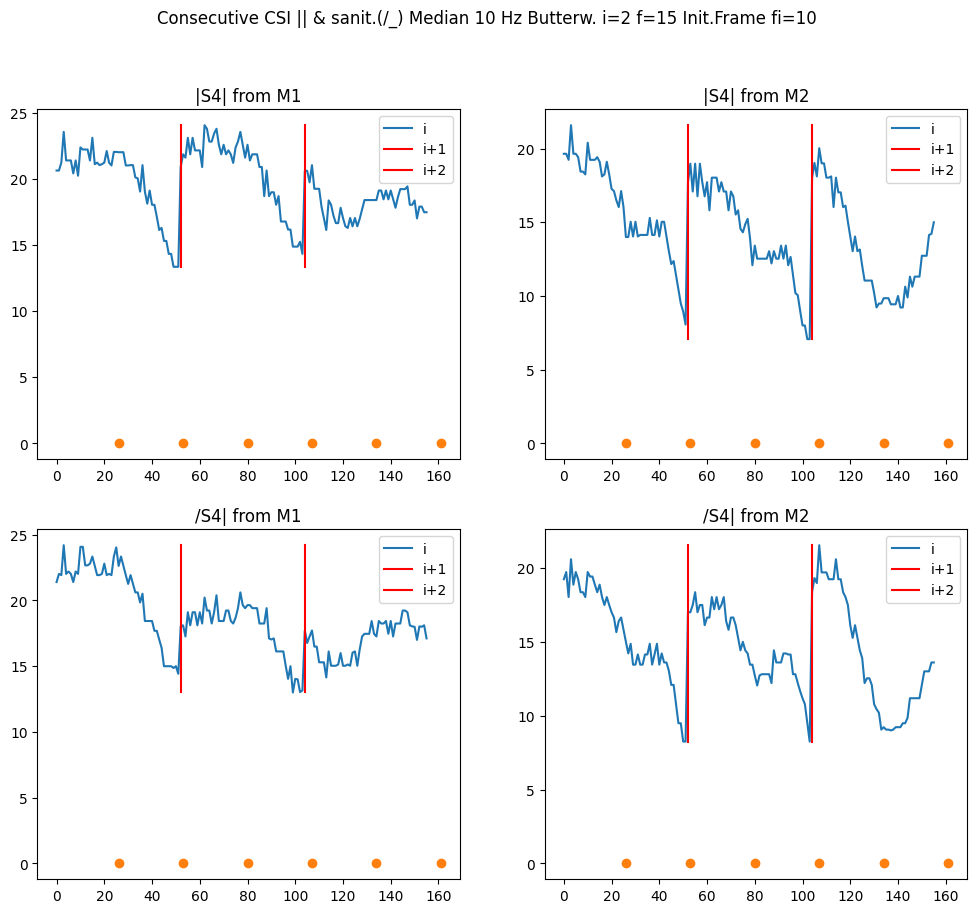

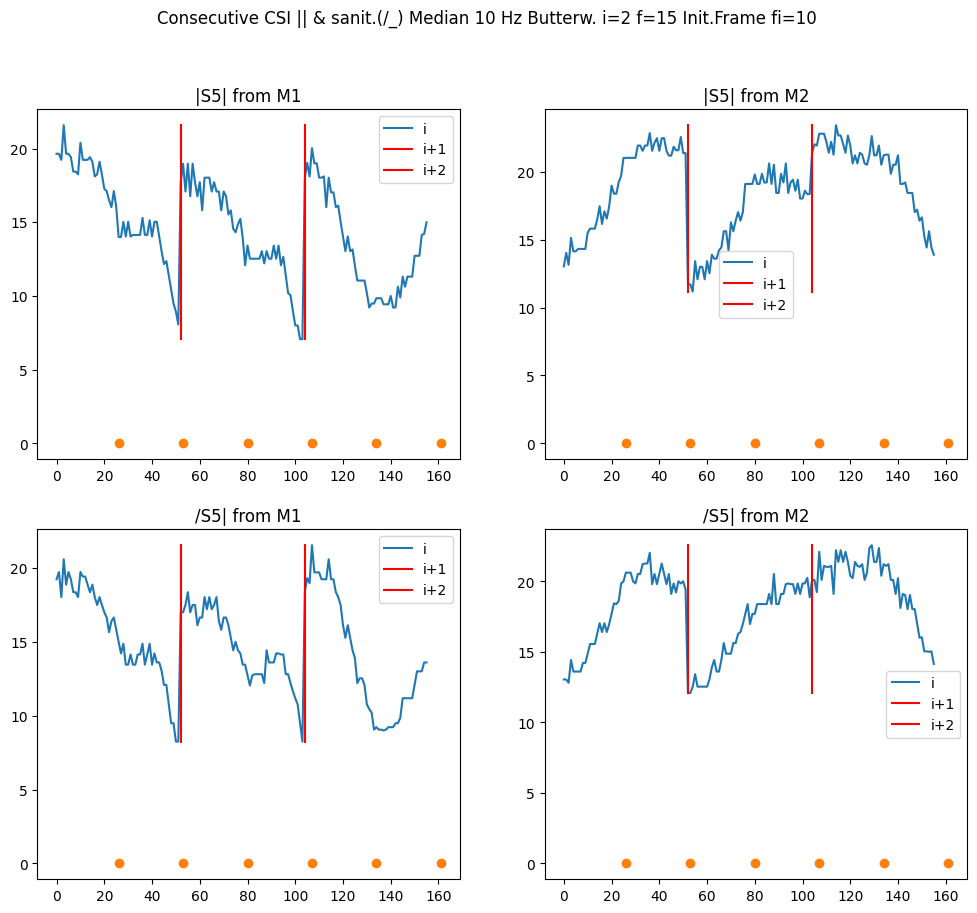

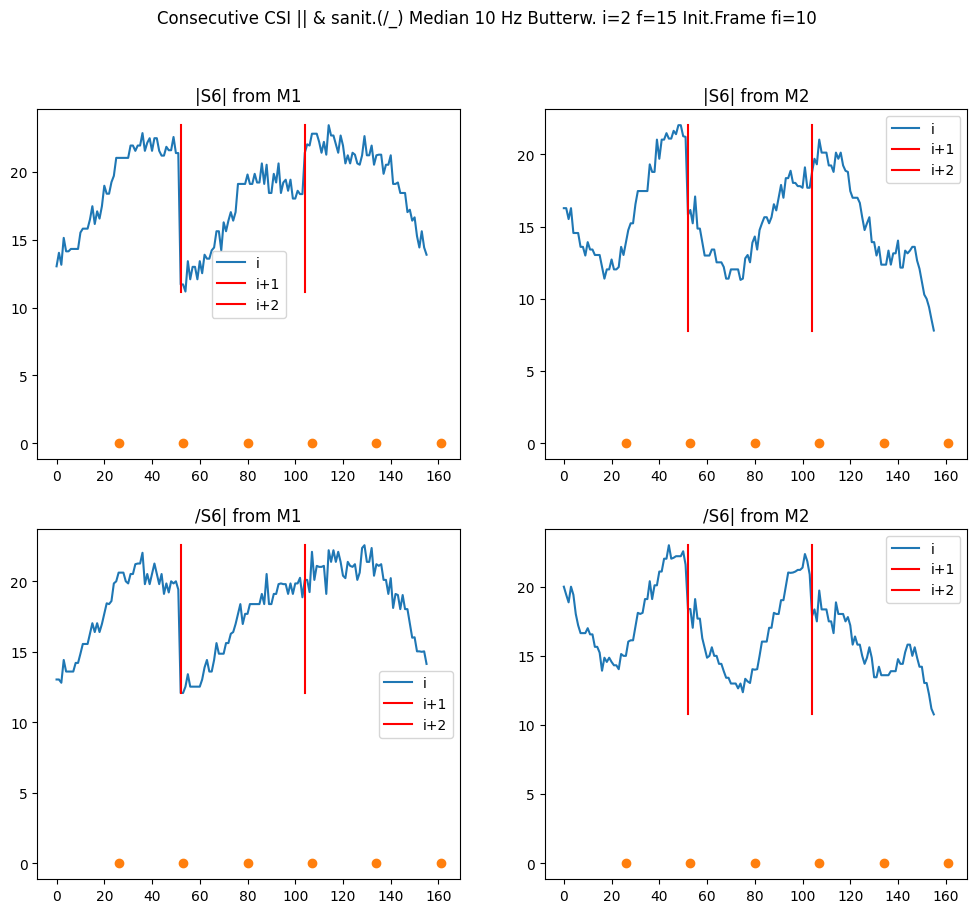

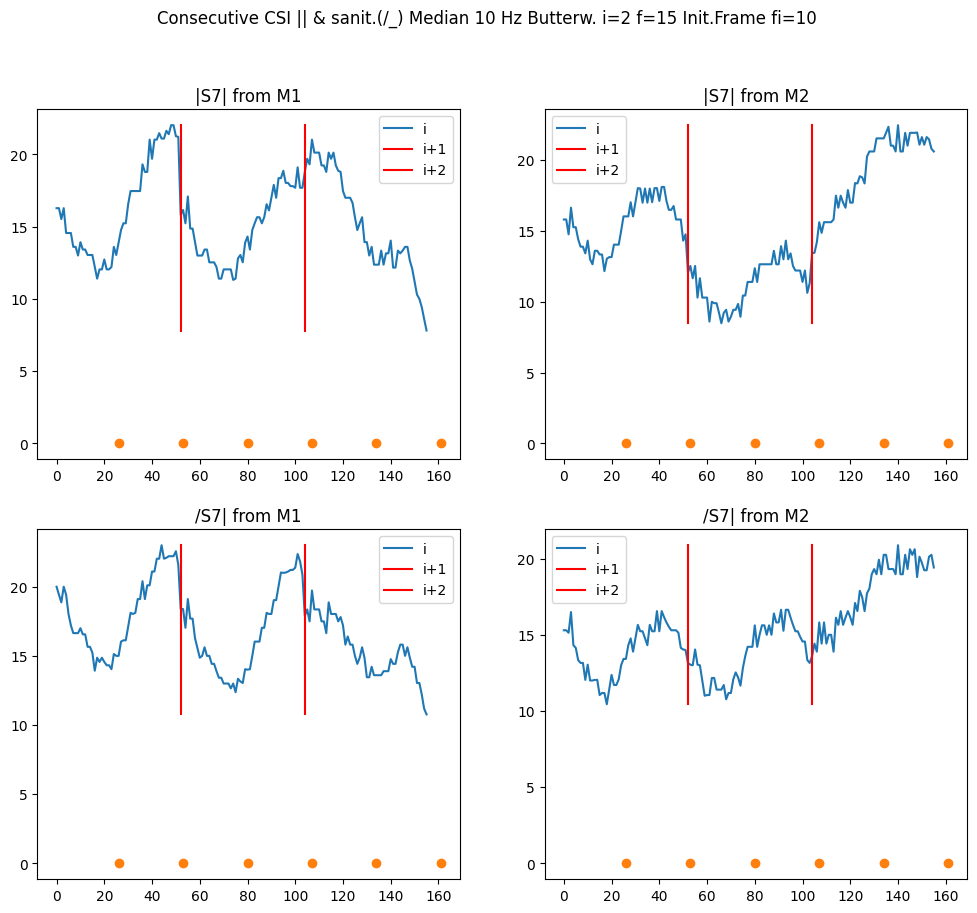

In [17]:
plotModPhaCarr6Sens()

In [19]:
plotS3_5c_all_c()

(13, 1, 60, 520)
trainx (13, 1, 60, 520) abs31 (0,)
(0,) 153 7956


ValueError: cannot reshape array of size 0 into shape (153,52)

(13, 1, 60, 520)


IndexError: index 13 is out of bounds for axis 0 with size 13

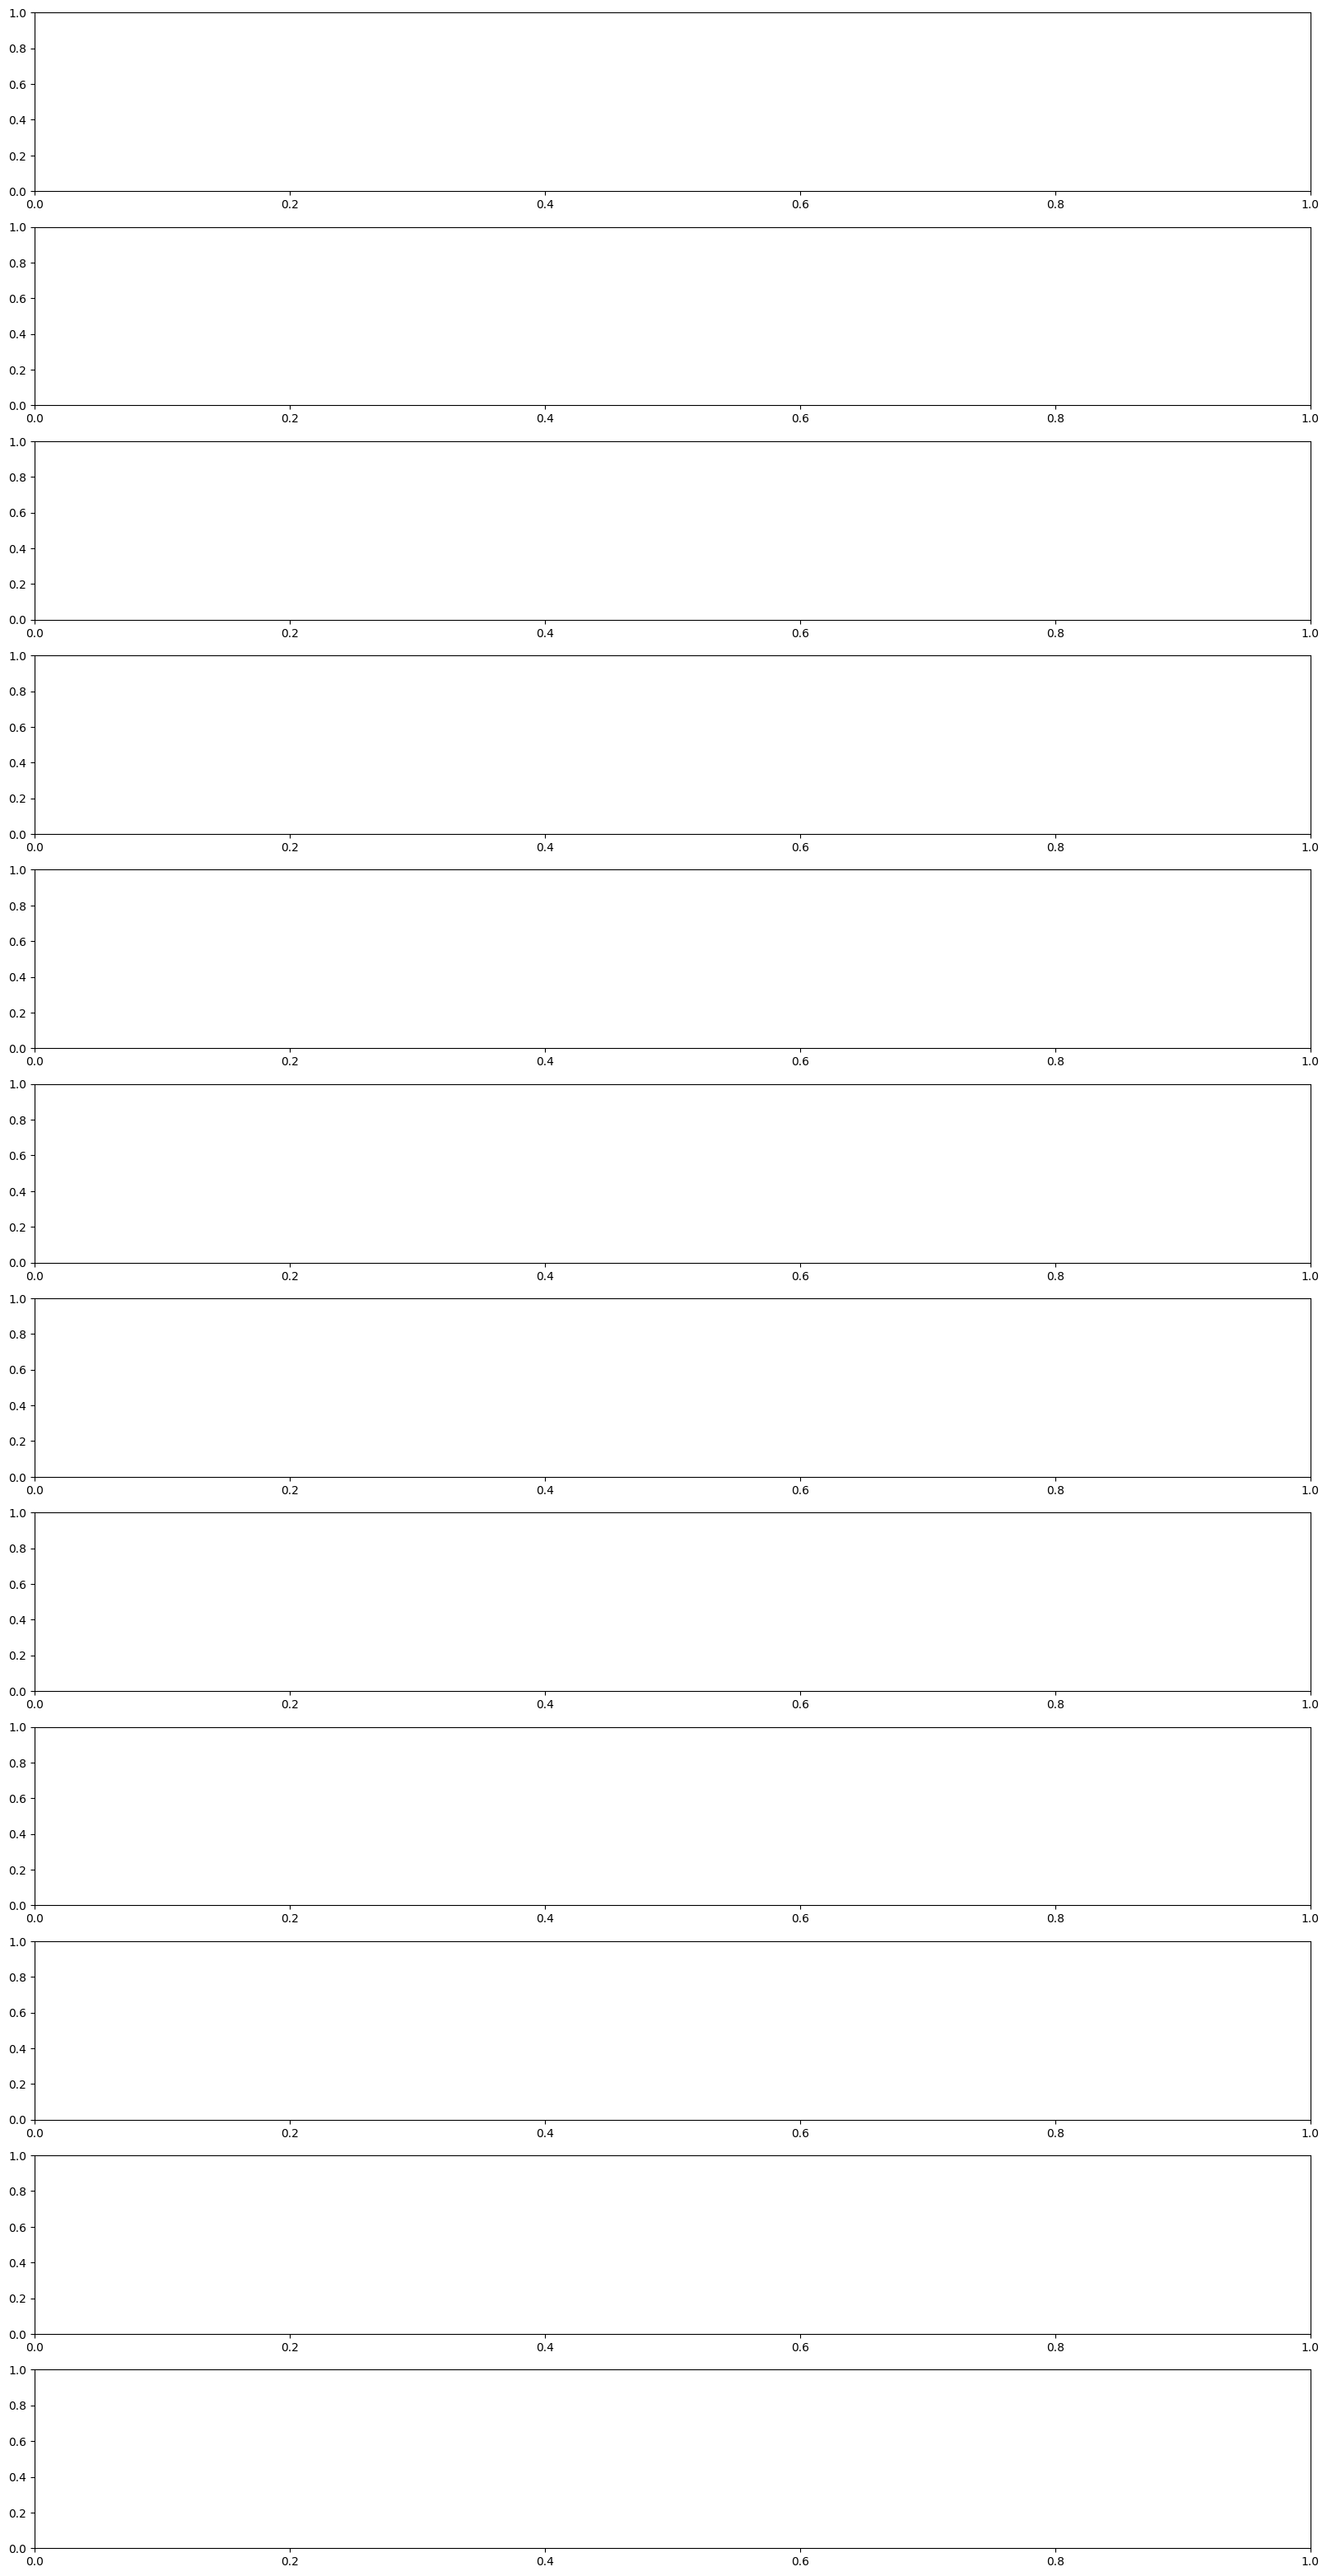

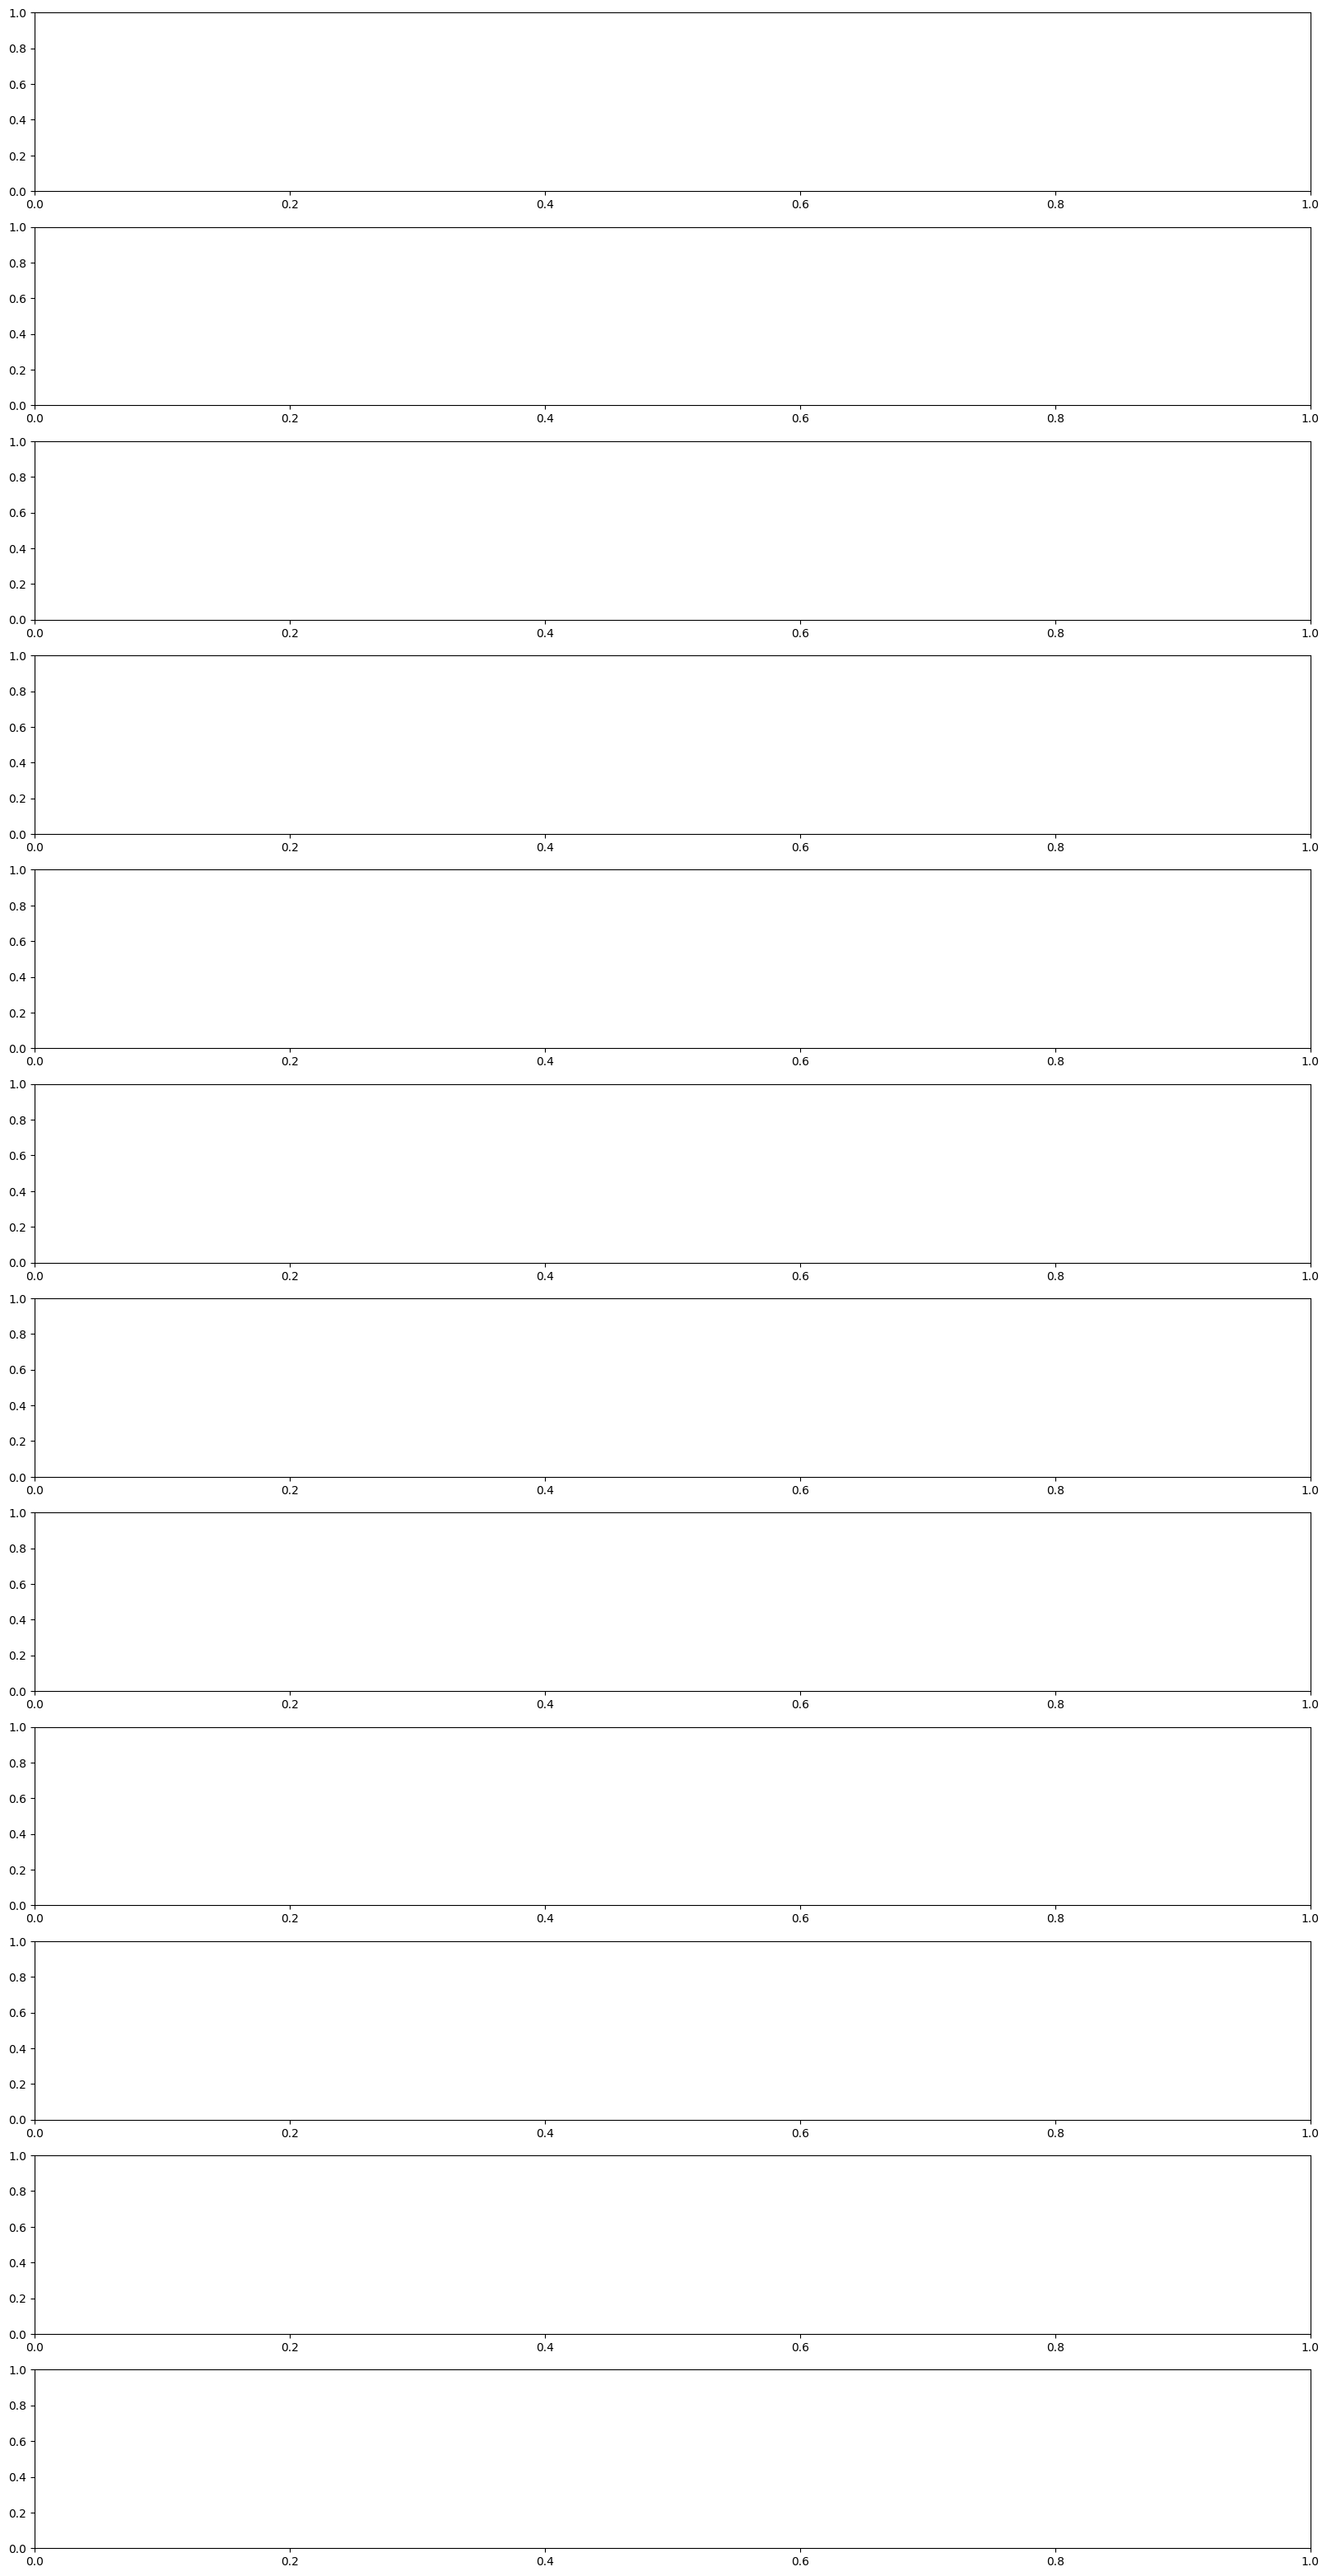

In [20]:
plotHAR12Sensors()

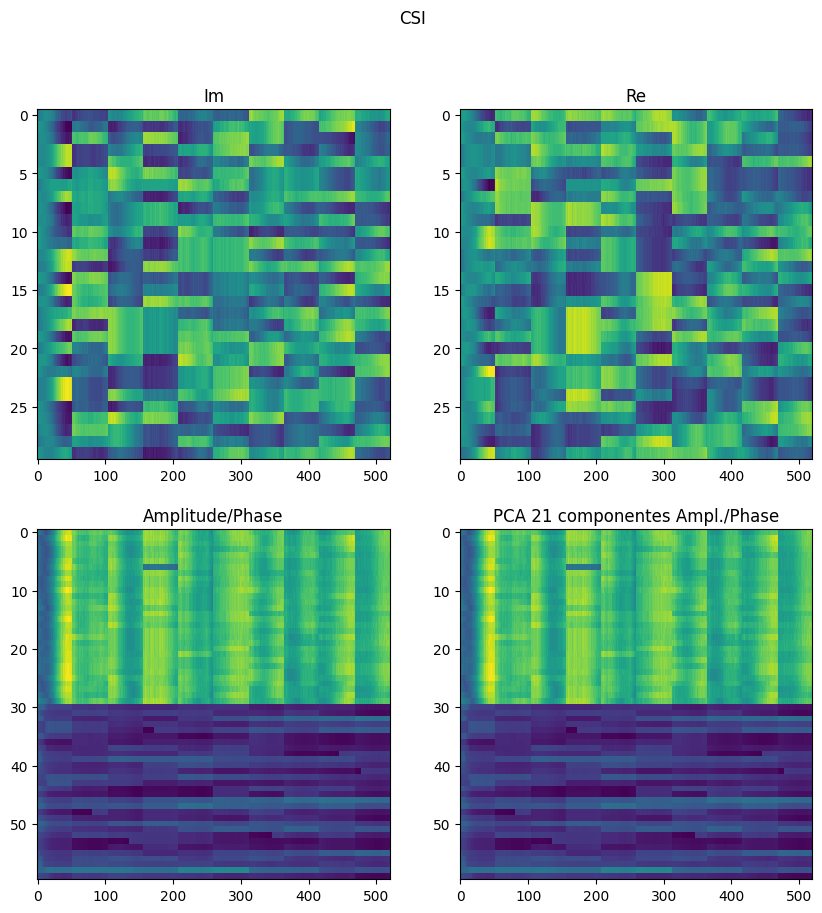

In [21]:
fig, axs = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('CSI')
axs[0,0].imshow(imgI, interpolation='nearest',aspect='auto')
axs[0,0].title.set_text('Im')
axs[0,1].imshow(imgR, interpolation='nearest',aspect='auto')
axs[0,1].title.set_text('Re')

axs[1,0].imshow(ab, interpolation='nearest',aspect='auto')
axs[1,0].title.set_text('Amplitude/Phase')
axs[1,1].imshow(abPCA, interpolation='nearest',aspect='auto')
axs[1,1].title.set_text('PCA 21 componentes Ampl./Phase')

experiment ex: 0
Array size: 13
Current index (k): 0
pca.explained_variance_ratio_ [9.47268945e-01 1.83153282e-02 1.24839424e-02 6.60764527e-03
 3.54022769e-03 3.18691913e-03 1.72648610e-03 1.58642079e-03
 1.19189905e-03 1.00494988e-03 7.16116525e-04 5.97210975e-04
 2.86012457e-04 1.80966184e-04 1.31344939e-04 1.19788211e-04
 9.33515532e-05 8.54146052e-05 7.72409107e-05 6.82017514e-05
 6.55430050e-05]
pca.singular_values_ [1338.93965211  186.1794341   153.70933053  111.82726752   81.85400812
   77.66223323   57.16179996   54.79406859   47.49458413   43.61105113
   36.81427068   33.61926722   23.26573772   18.50644782   15.76634494
   15.05675532   13.29184069   12.7142405    12.09060536   11.36114537
   11.13749514]
Array size: 13
Current index (k): 1
pca.explained_variance_ratio_ [9.37530875e-01 3.19490659e-02 1.26302284e-02 5.09324142e-03
 3.00808102e-03 2.33416554e-03 1.63022480e-03 1.45691388e-03
 1.15477886e-03 8.17723079e-04 5.65594599e-04 3.52926458e-04
 1.97140923e-04 1.2496367

C:\Users\Admin\AppData\Local\Temp\ipykernel_3456\3751569706.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fg, ax = plt.subplots(round(NFrames/6),6)


Array size: 13
Current index (k): 0
pca.explained_variance_ratio_ [9.47268945e-01 1.83153282e-02 1.24839424e-02 6.60764527e-03
 3.54022769e-03 3.18691913e-03 1.72648610e-03 1.58642079e-03
 1.19189905e-03 1.00494988e-03 7.16116525e-04 5.97210975e-04
 2.86012459e-04 1.80966190e-04 1.31344949e-04 1.19789880e-04
 9.33686175e-05 8.54159334e-05 7.72907564e-05 6.81845573e-05
 6.55339466e-05]
pca.singular_values_ [1338.93965211  186.1794341   153.70933053  111.82726752   81.85400812
   77.66223323   57.16179996   54.79406859   47.49458413   43.61105113
   36.81427068   33.61926722   23.26573777   18.50644813   15.76634558
   15.05686023   13.29305548   12.71433935   12.09450593   11.35971317
   11.13672549]
Array size: 13
Current index (k): 1
pca.explained_variance_ratio_ [9.37530875e-01 3.19490659e-02 1.26302284e-02 5.09324142e-03
 3.00808102e-03 2.33416554e-03 1.63022480e-03 1.45691388e-03
 1.15477886e-03 8.17723079e-04 5.65594599e-04 3.52926458e-04
 1.97140921e-04 1.24963695e-04 1.04288394e

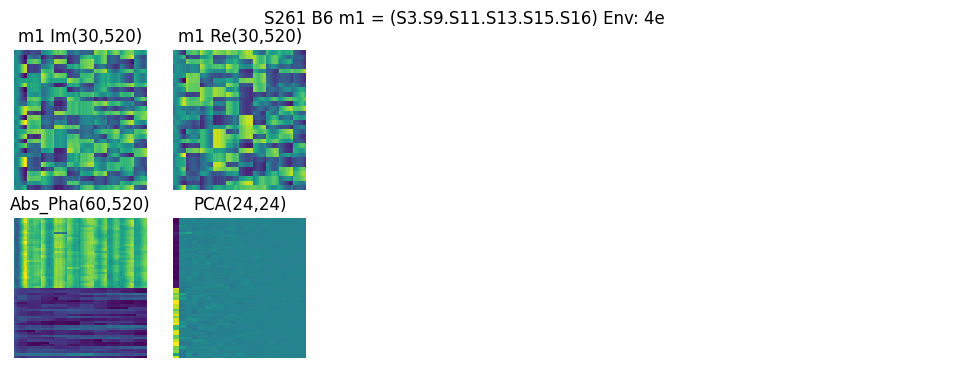

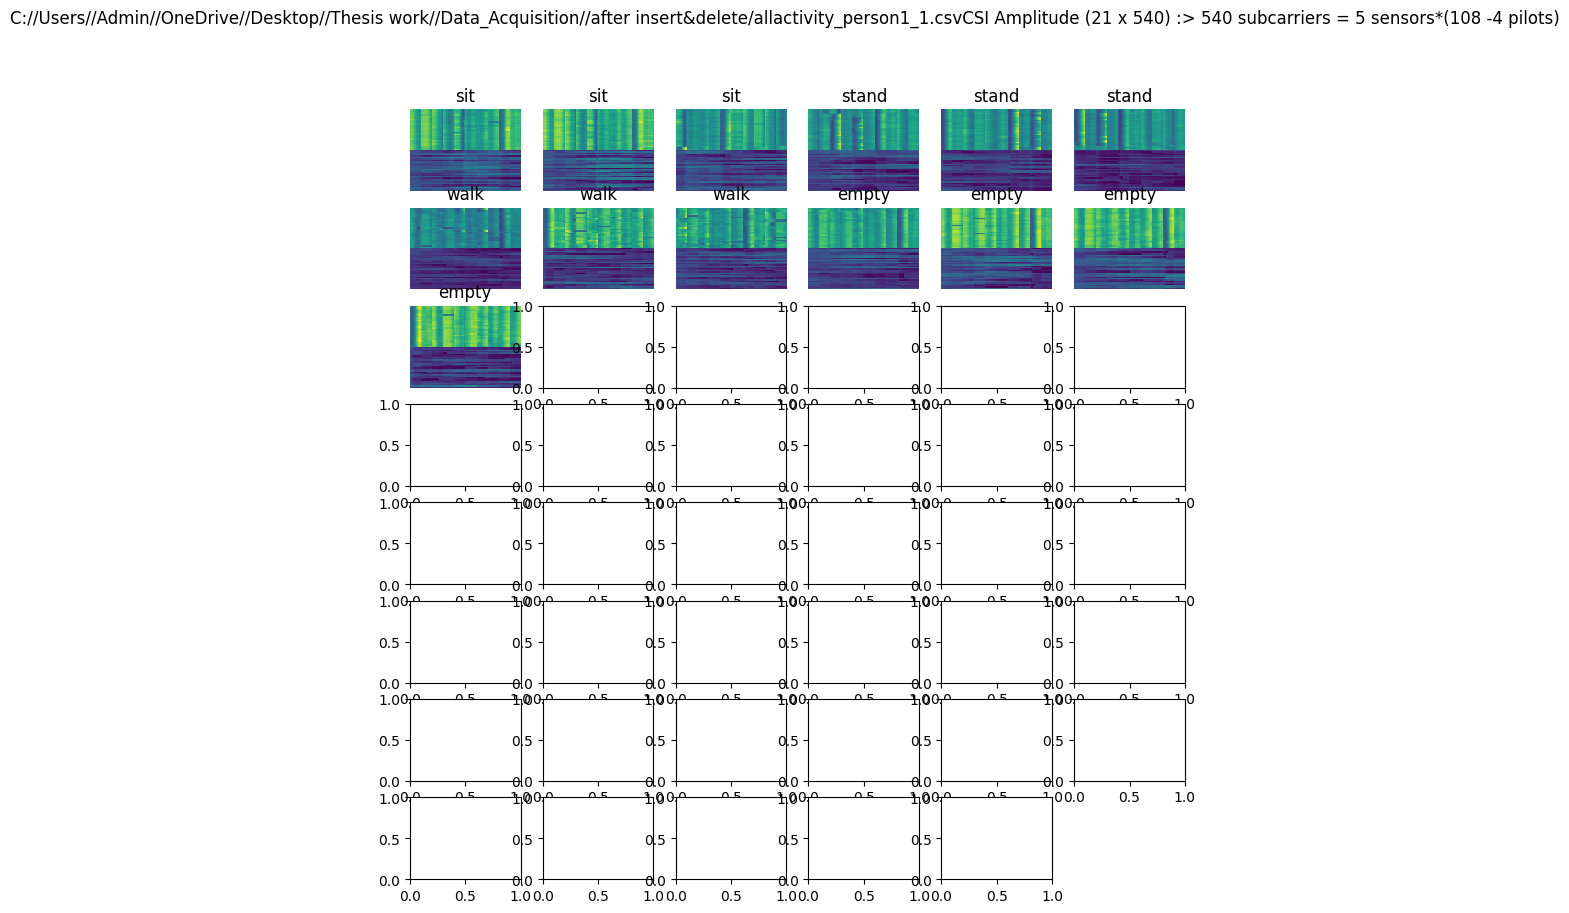

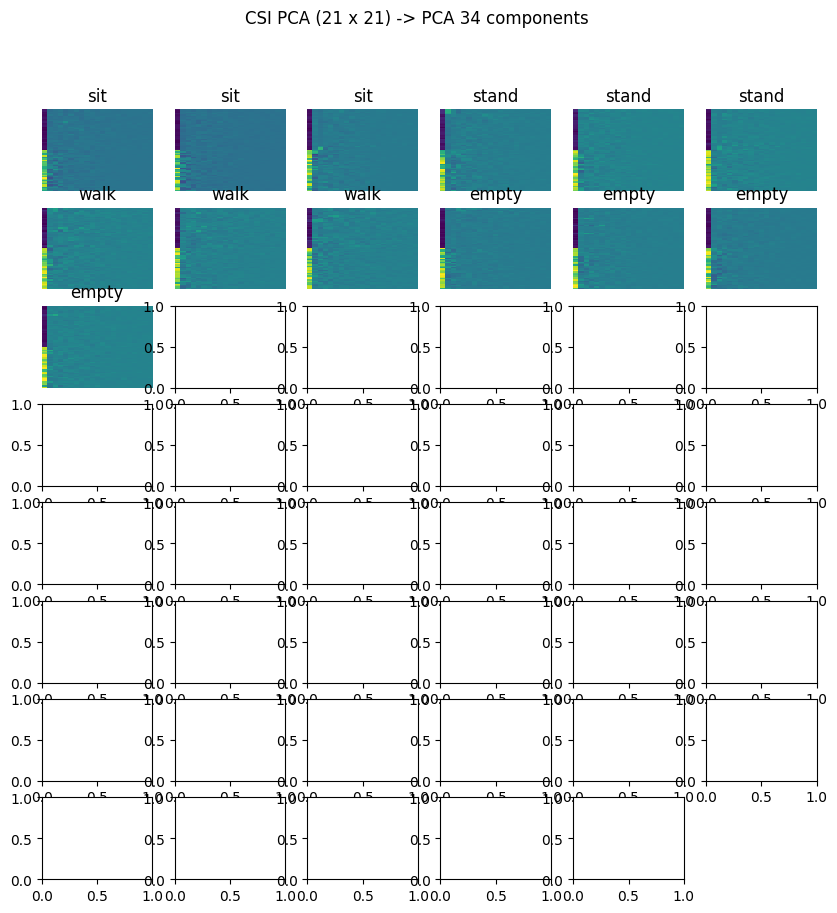

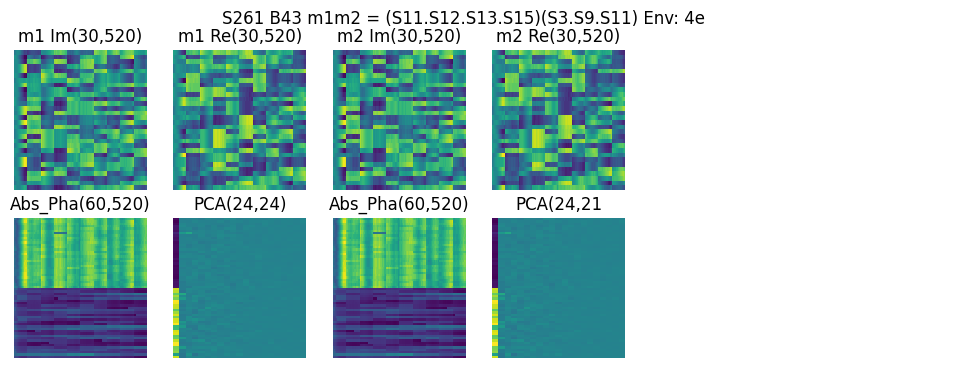

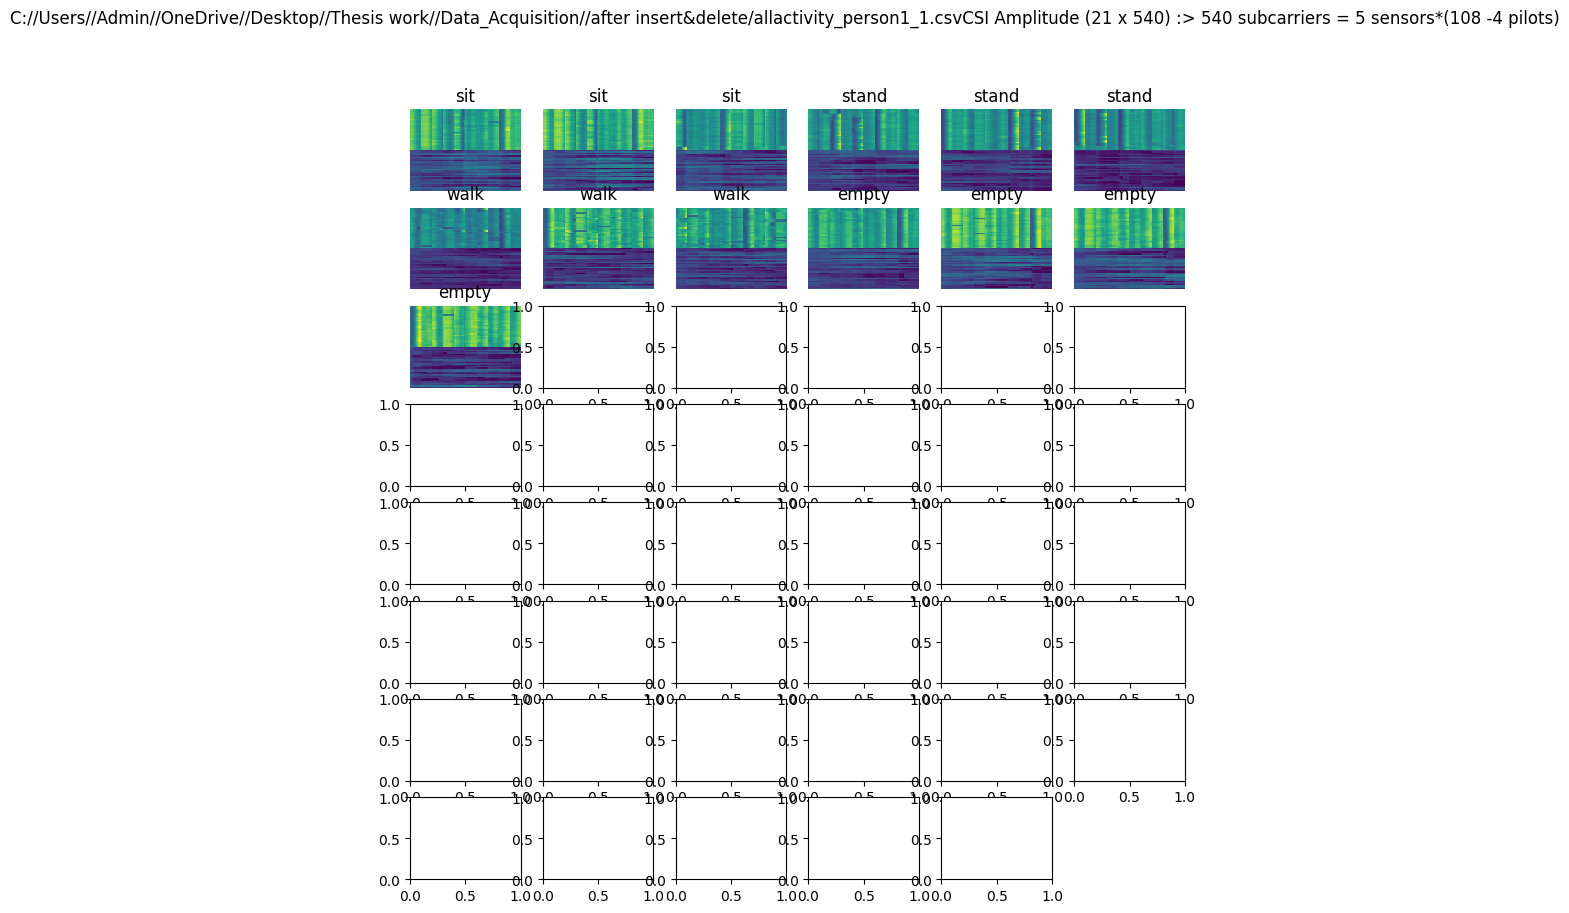

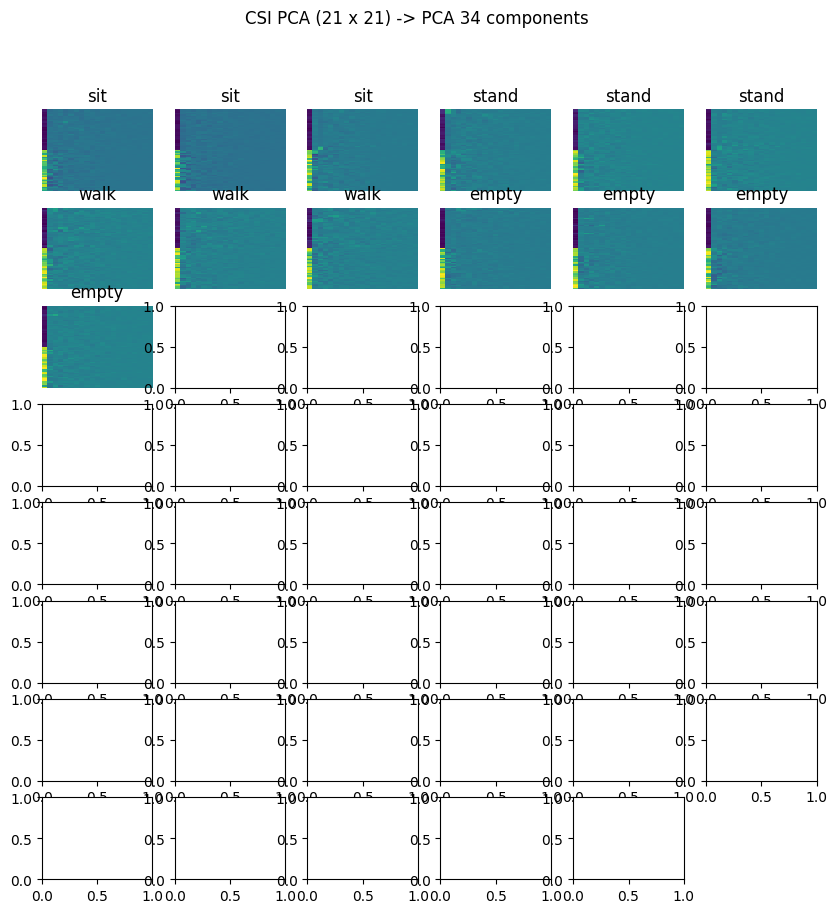

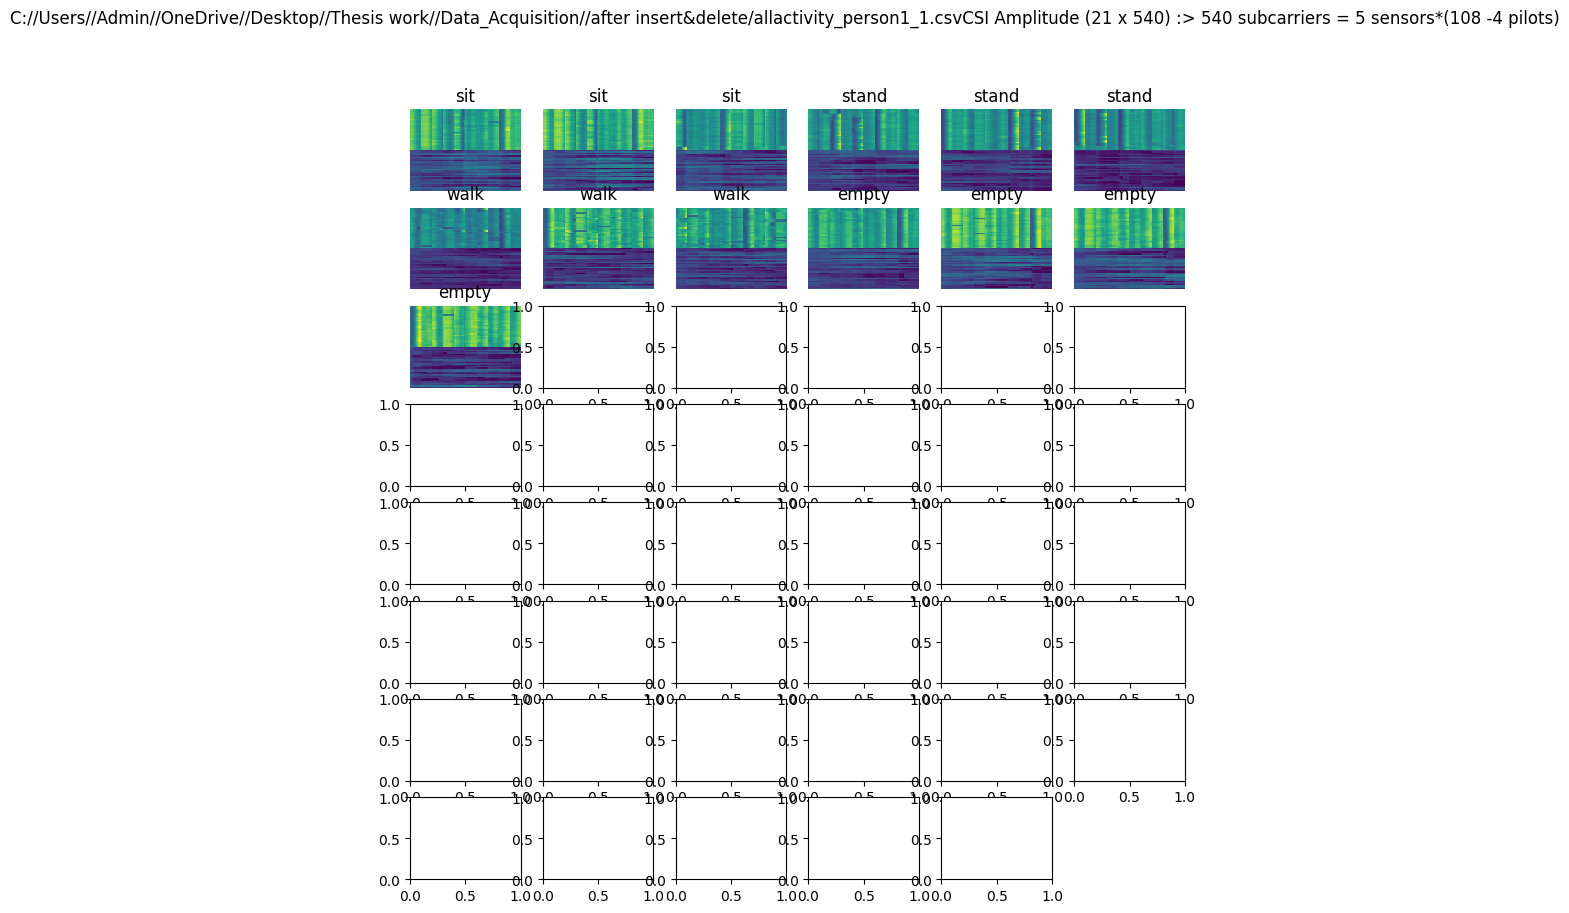

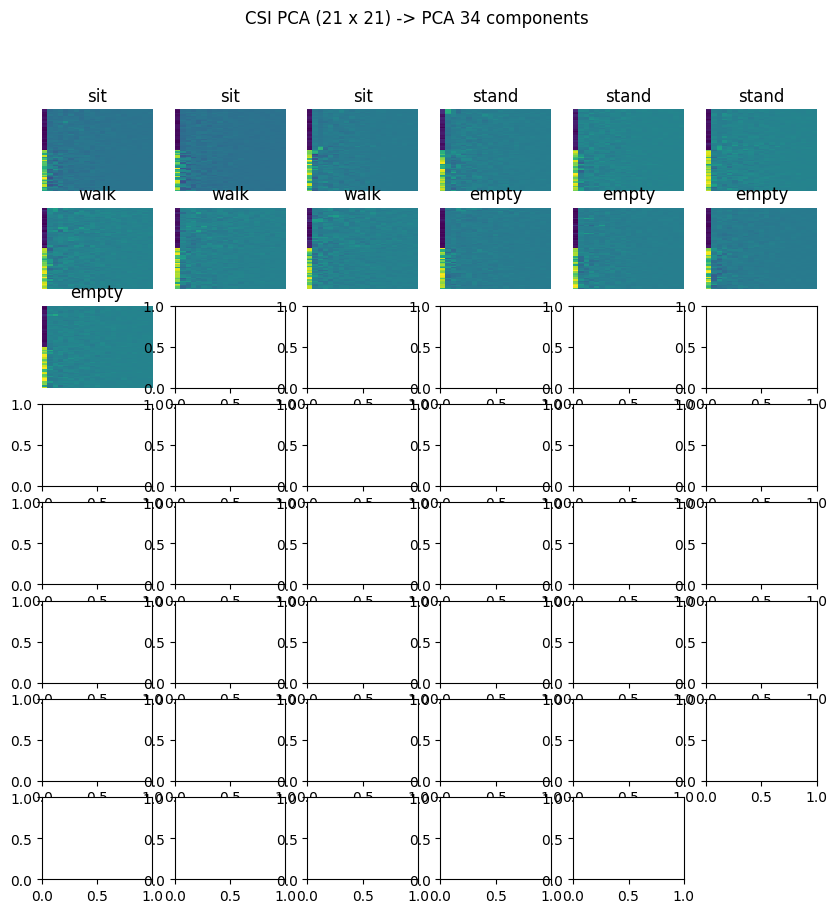

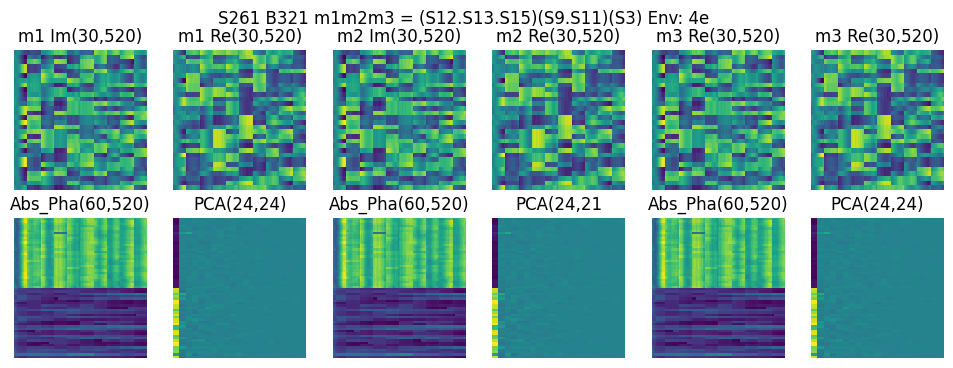

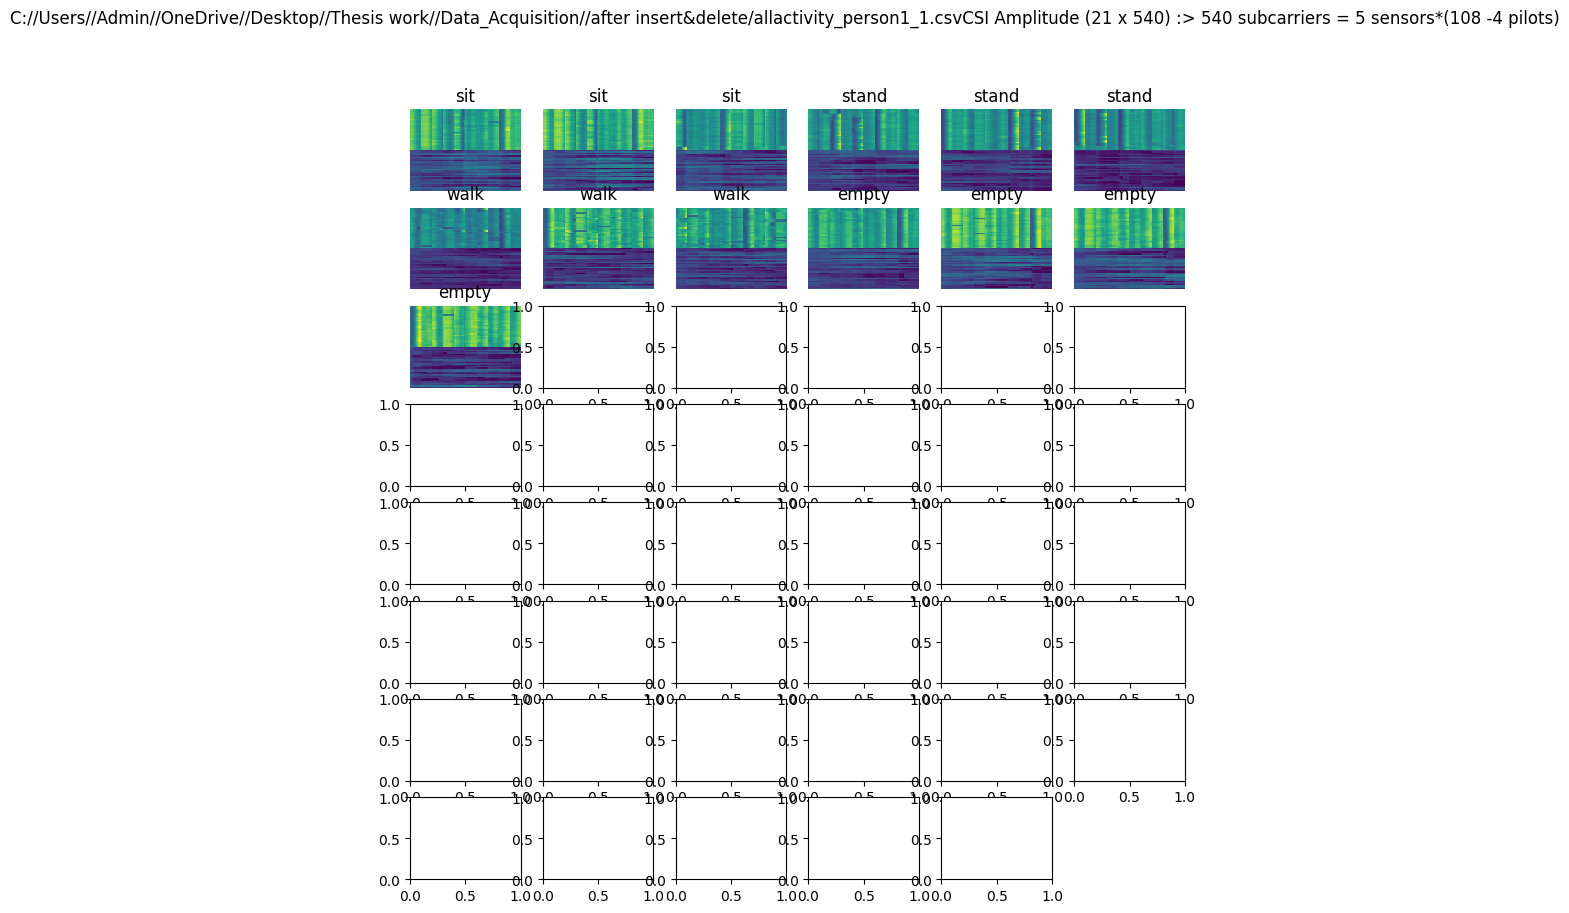

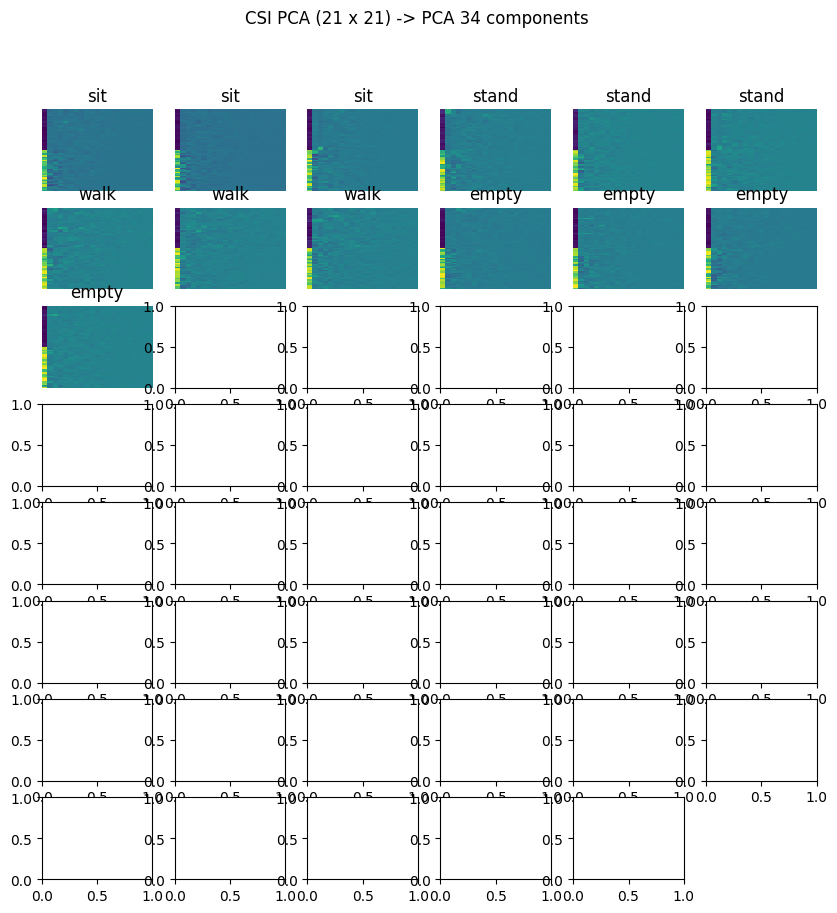

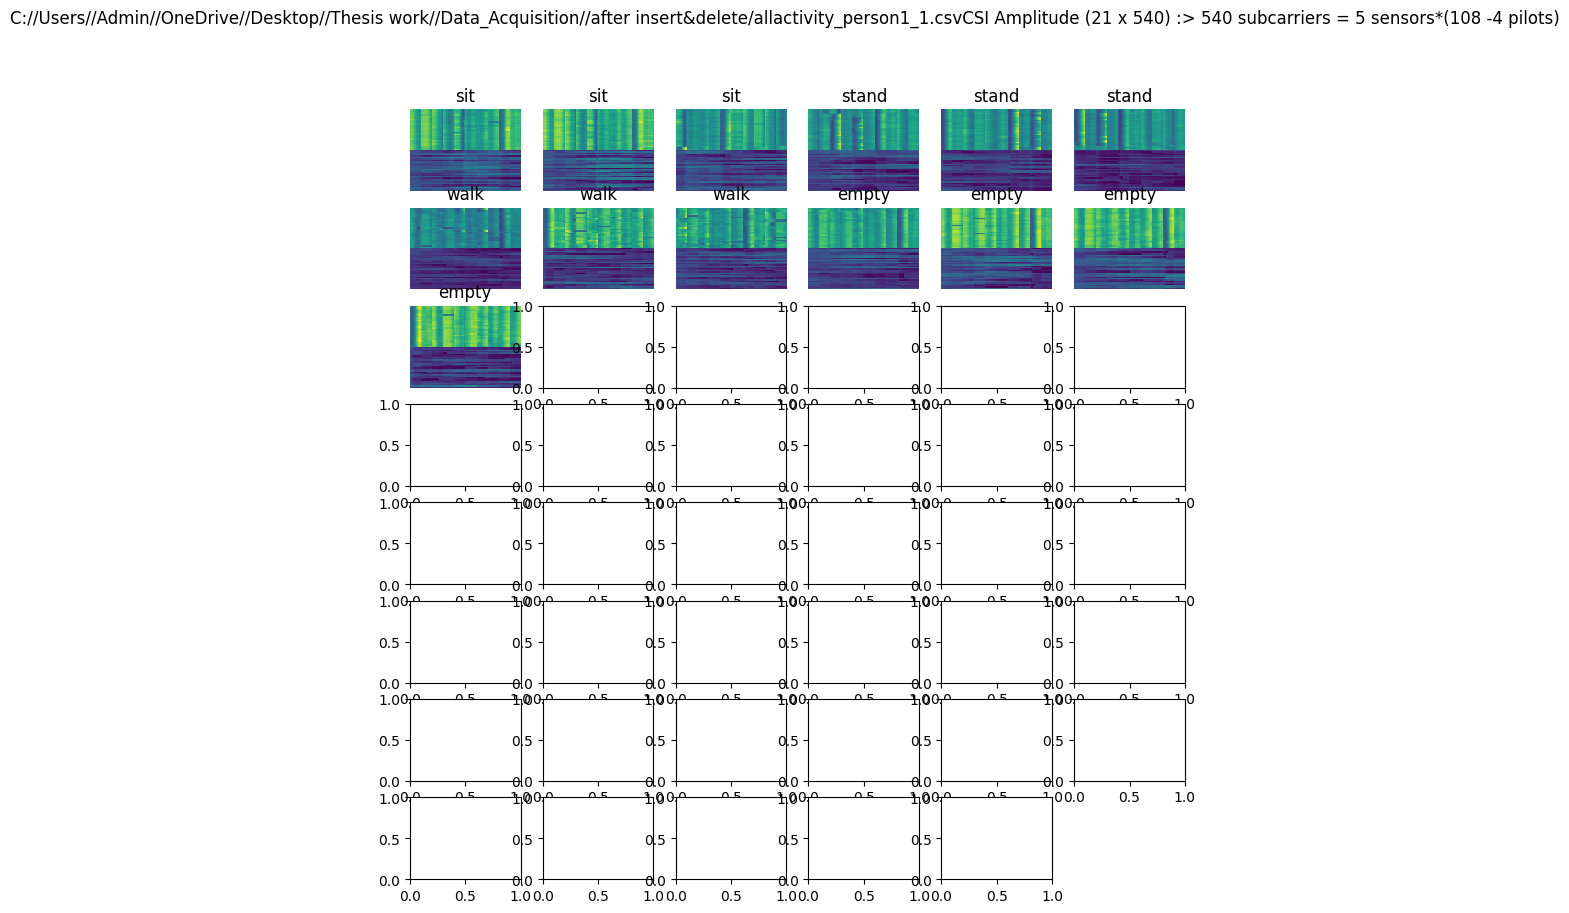

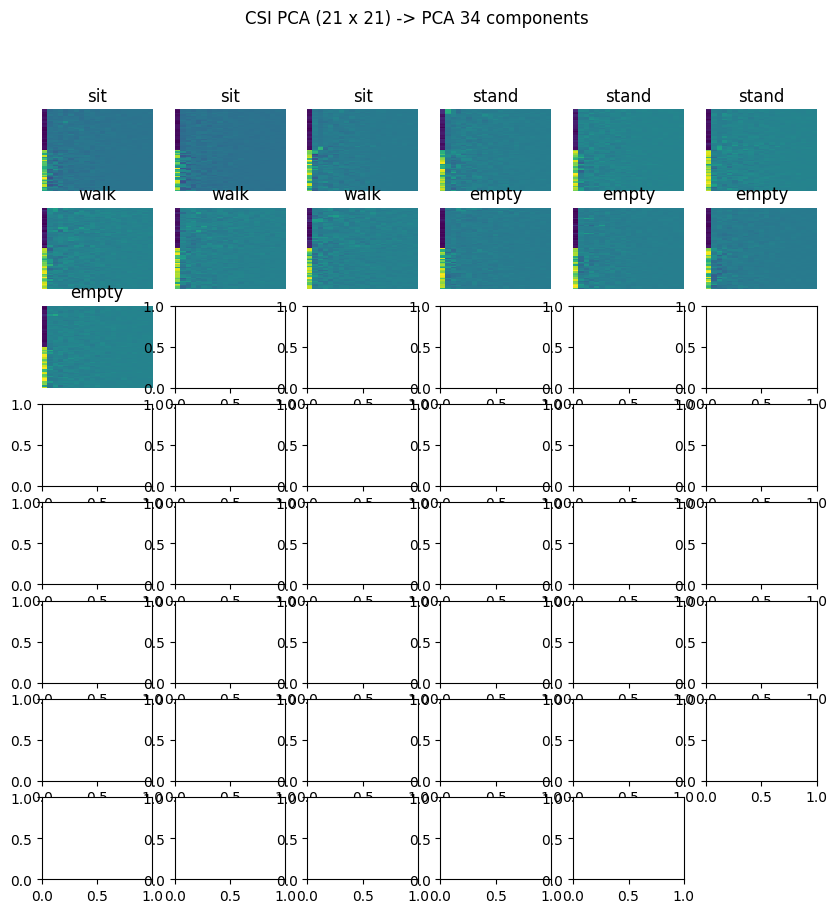

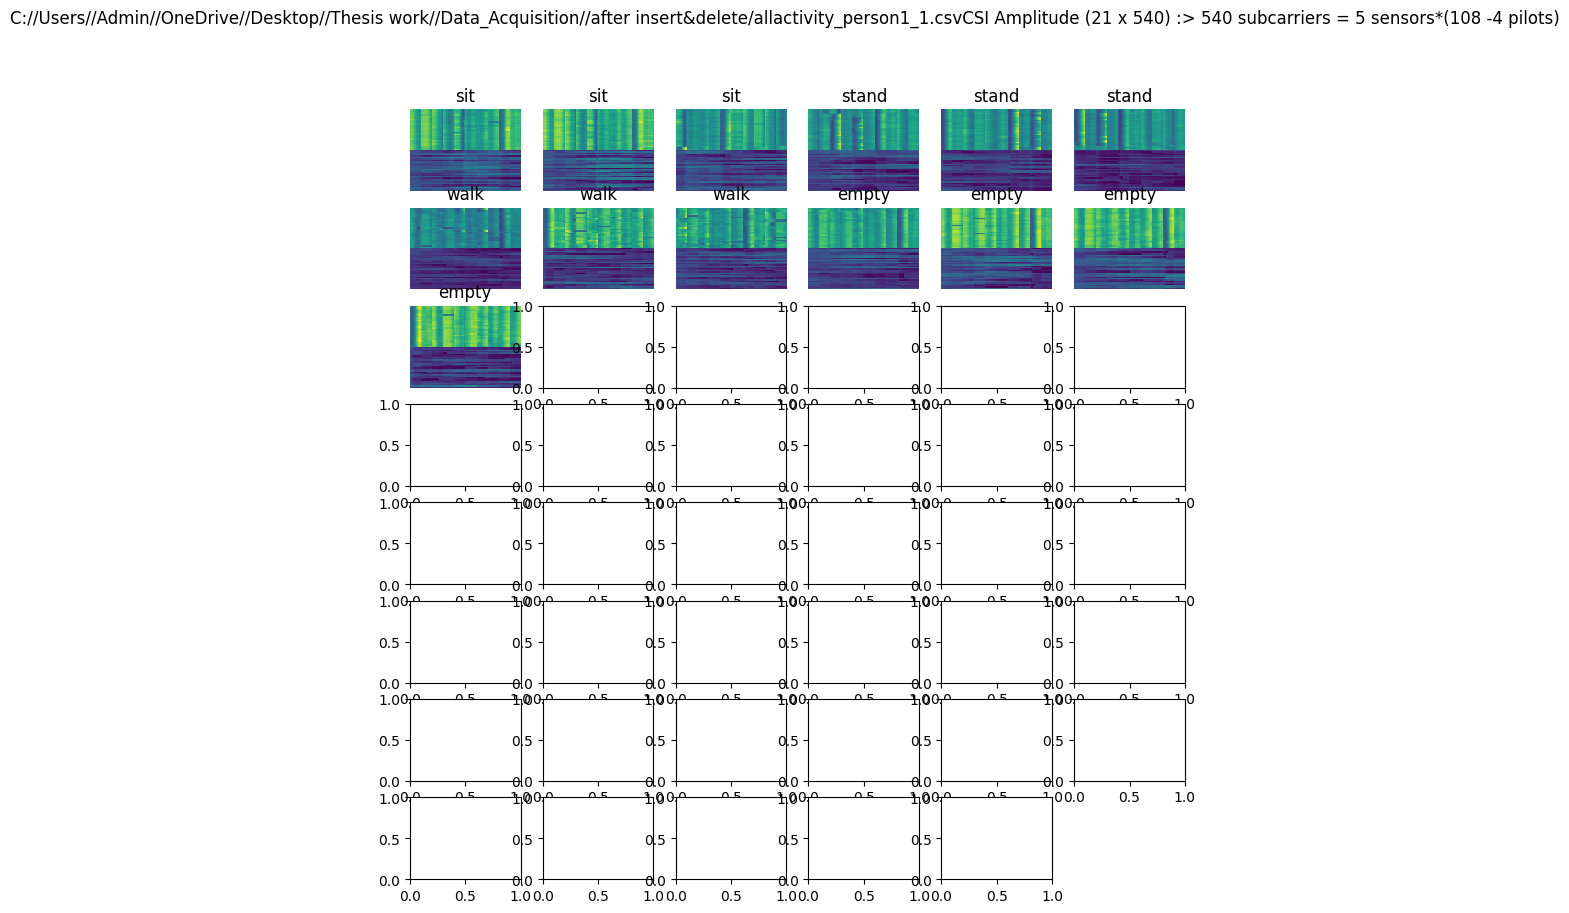

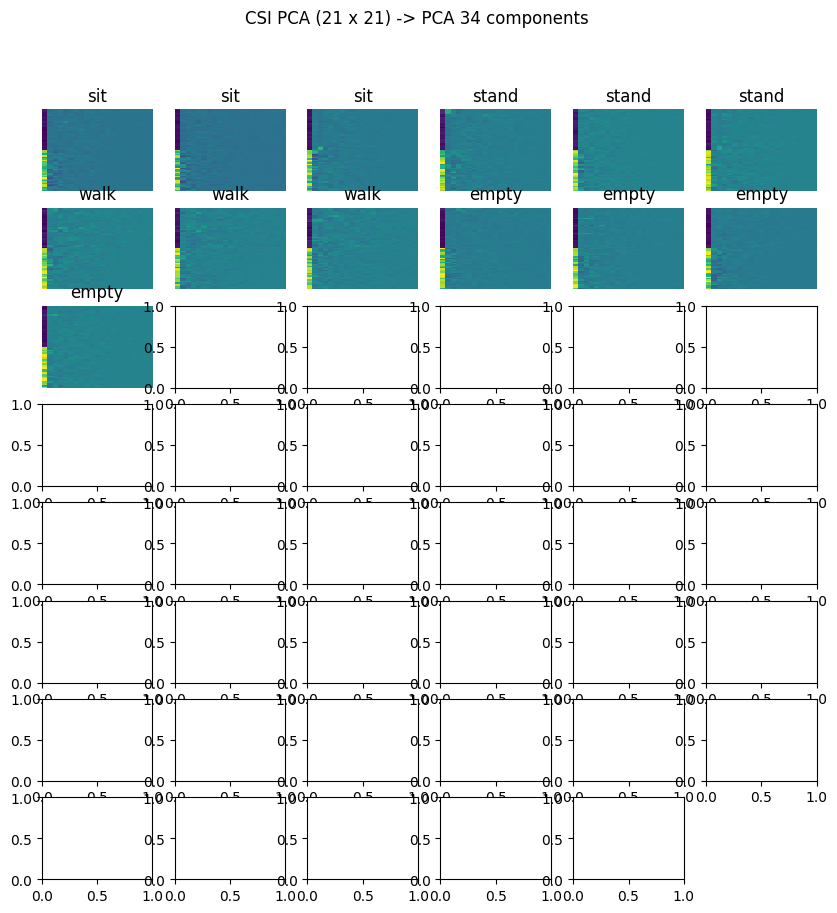

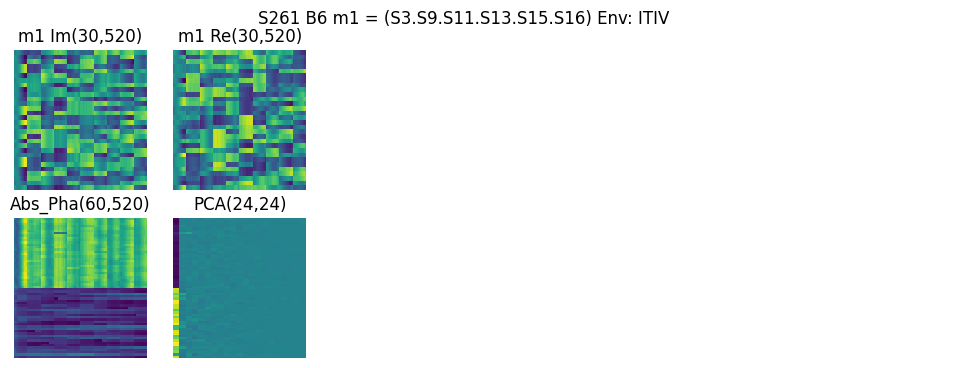

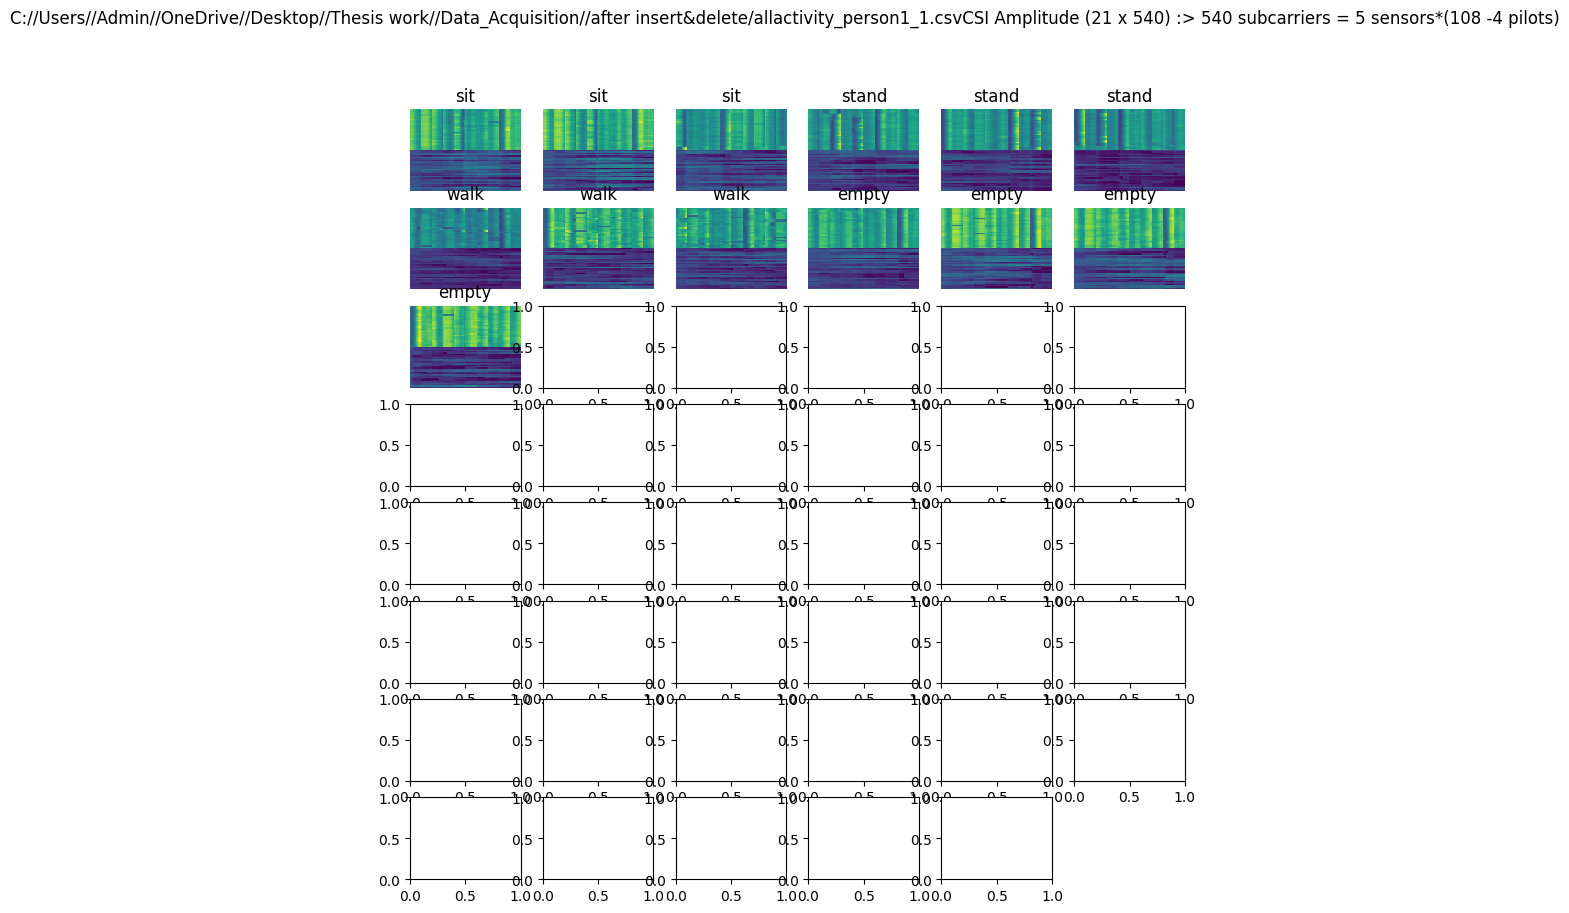

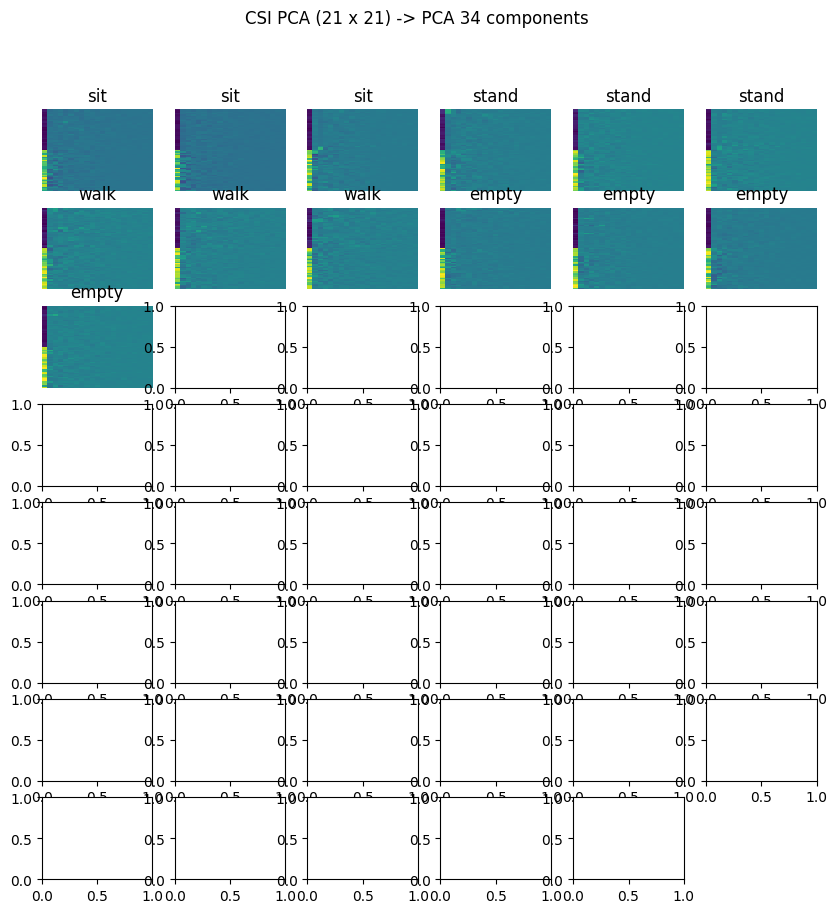

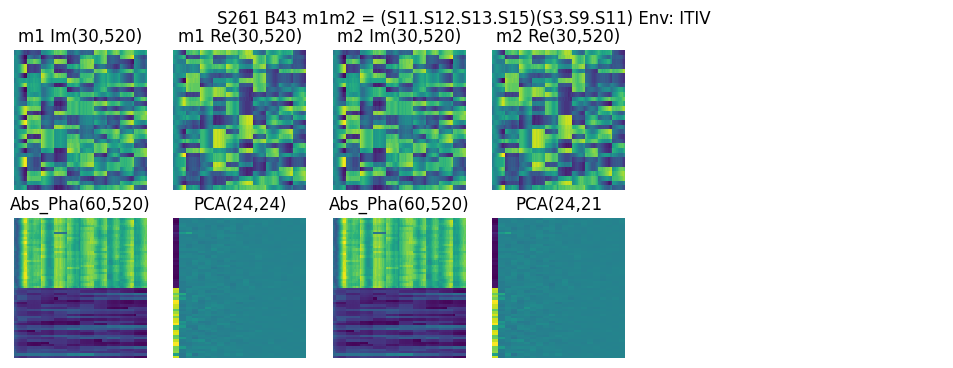

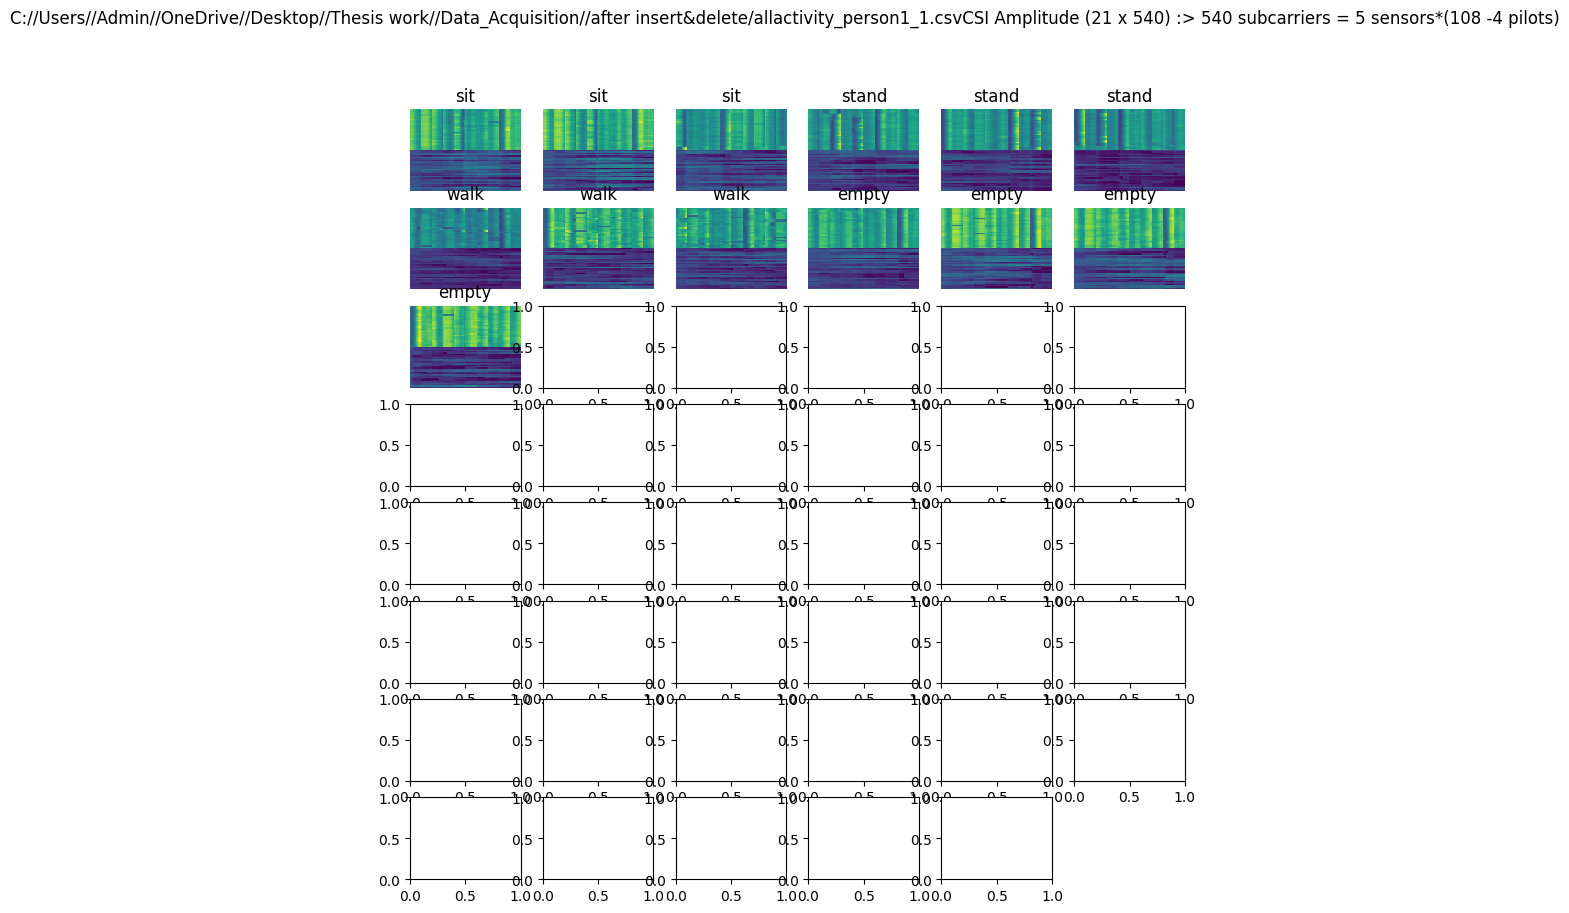

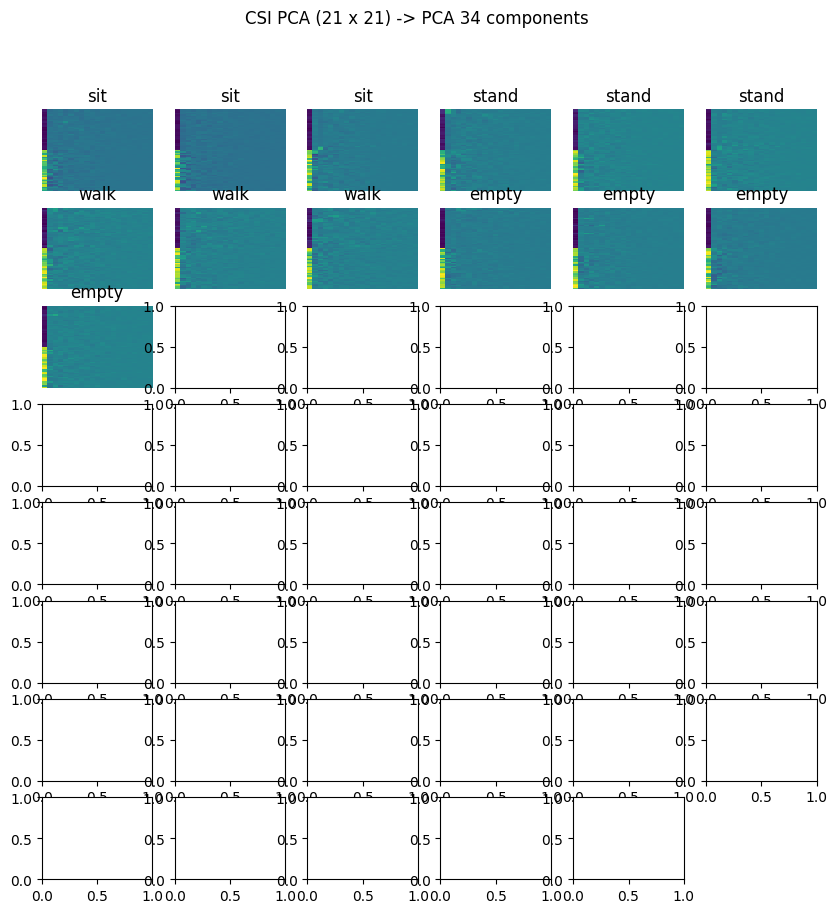

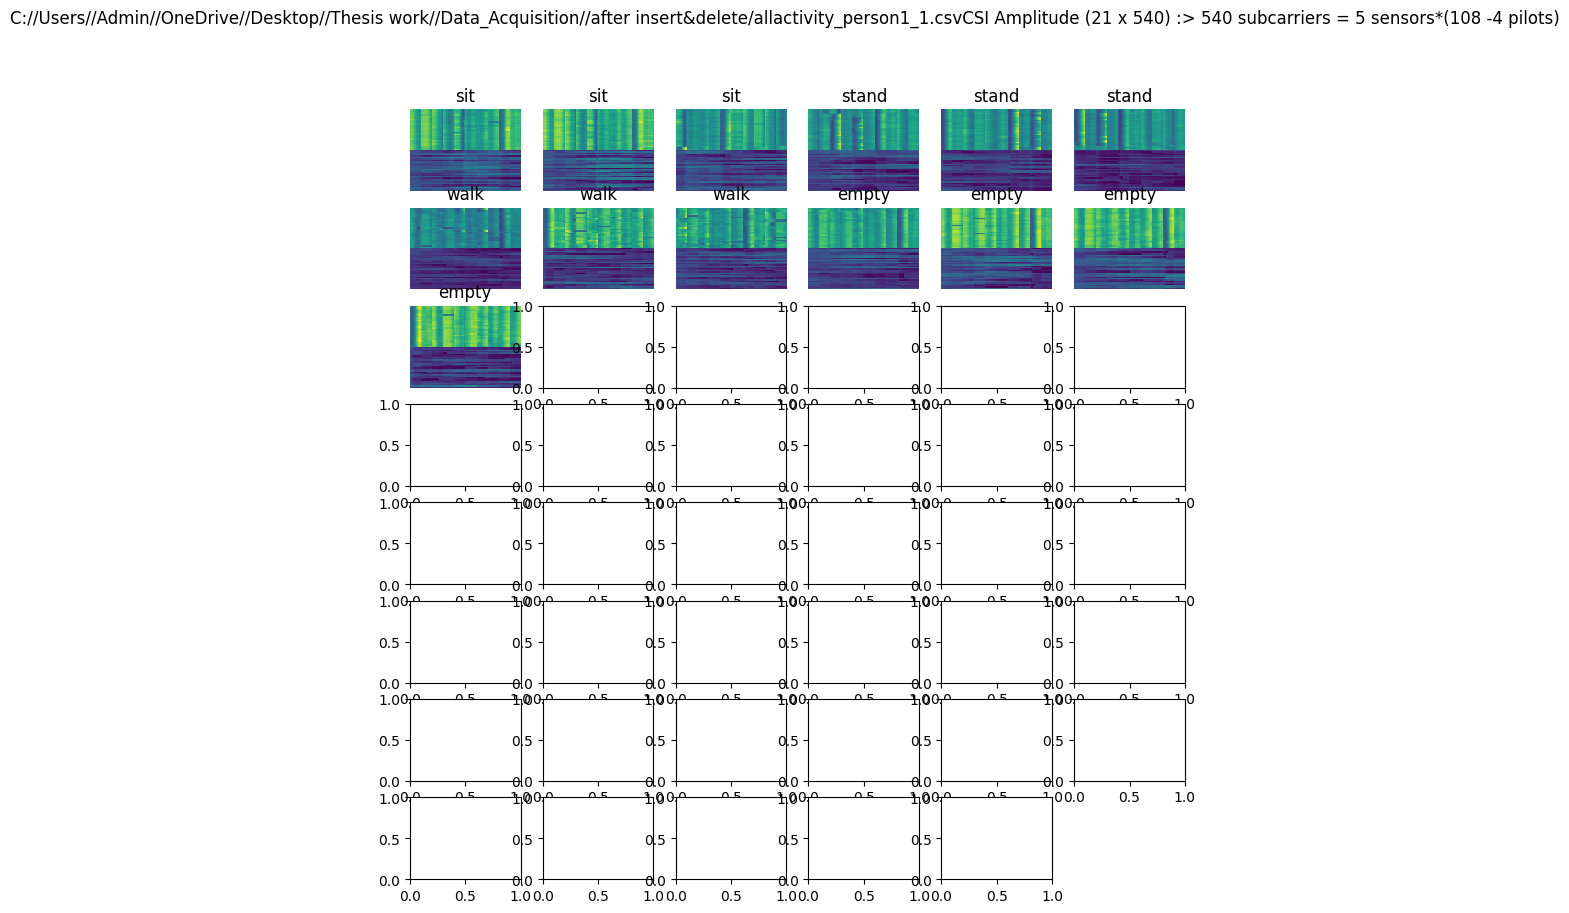

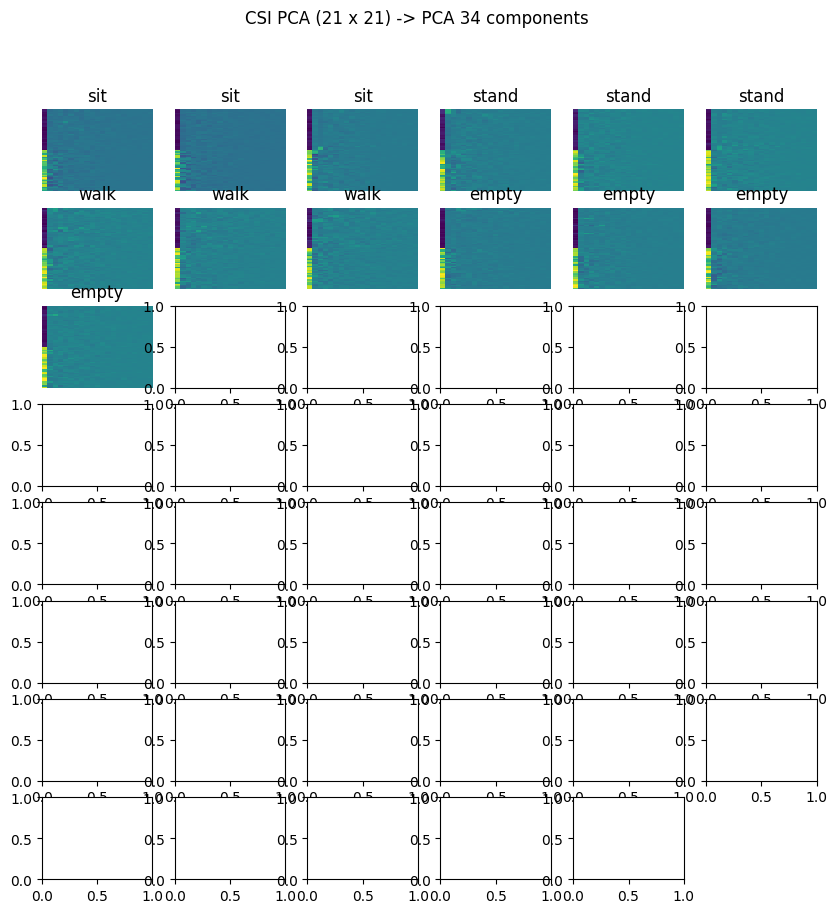

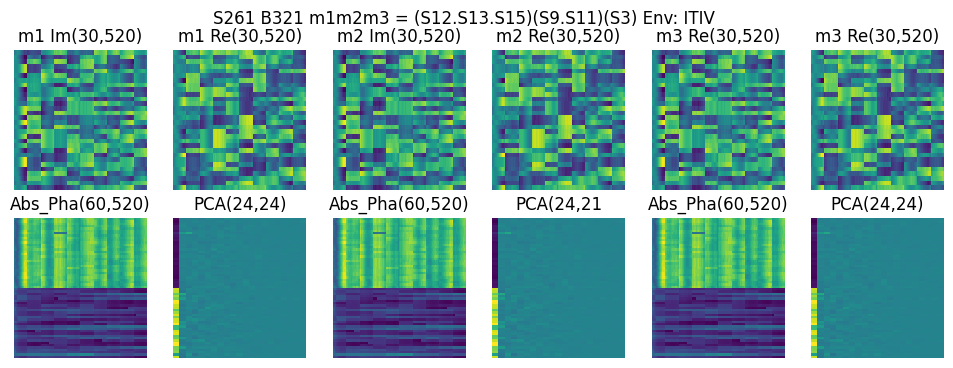

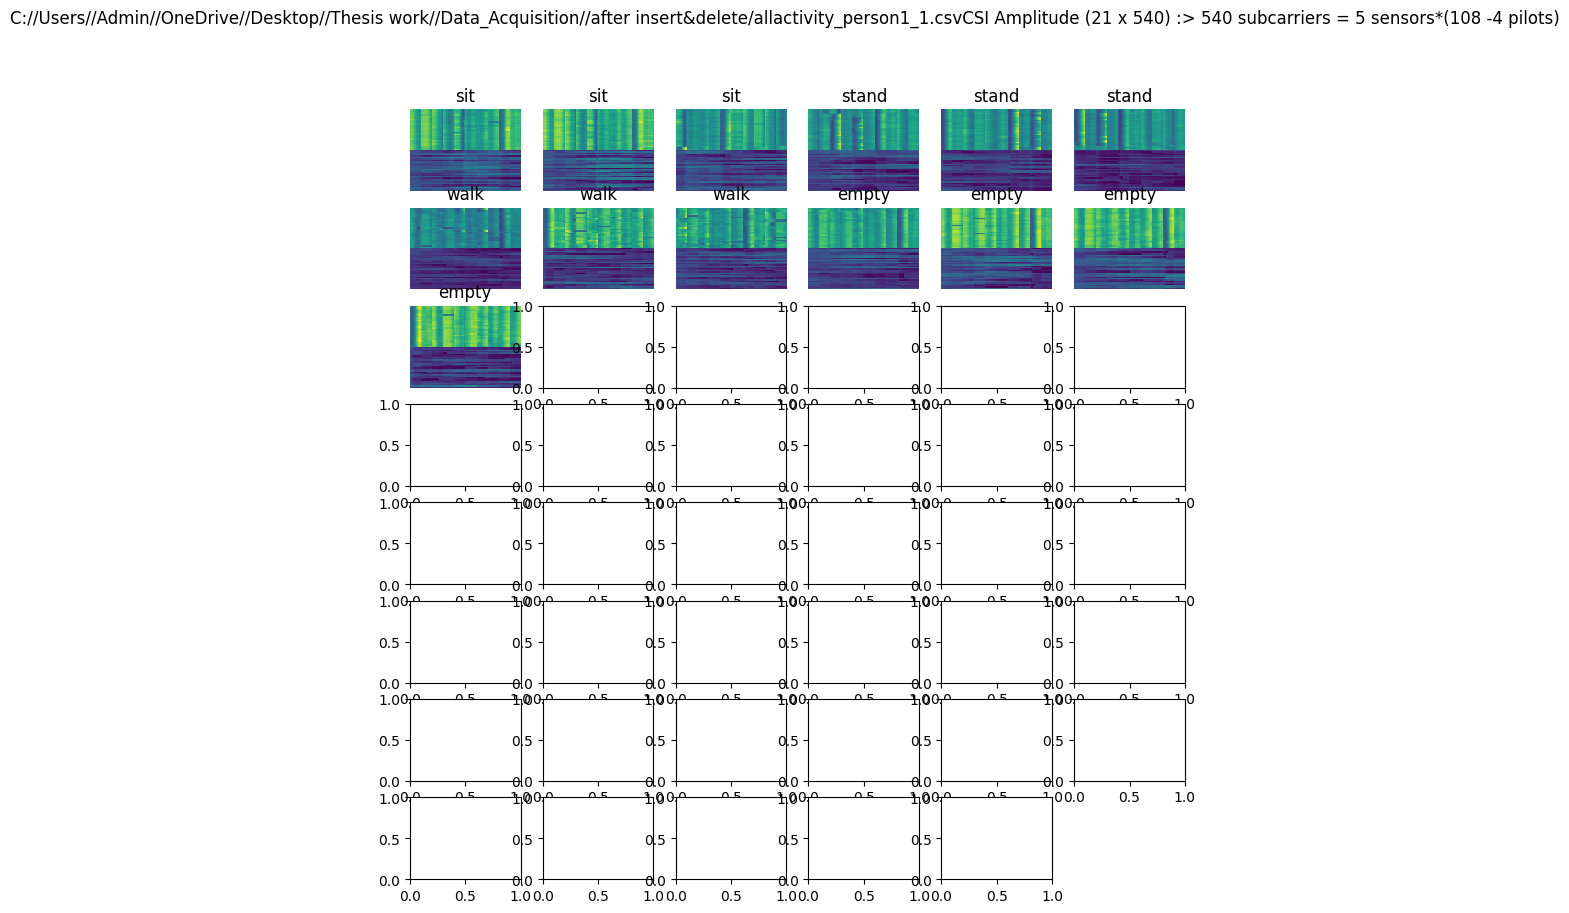

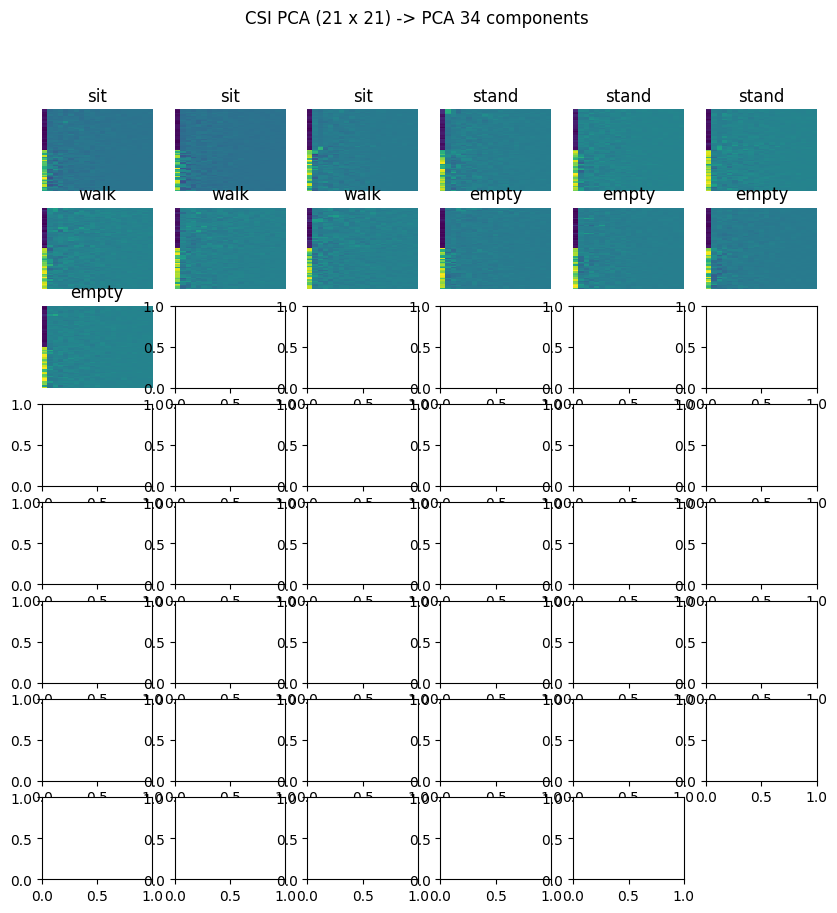

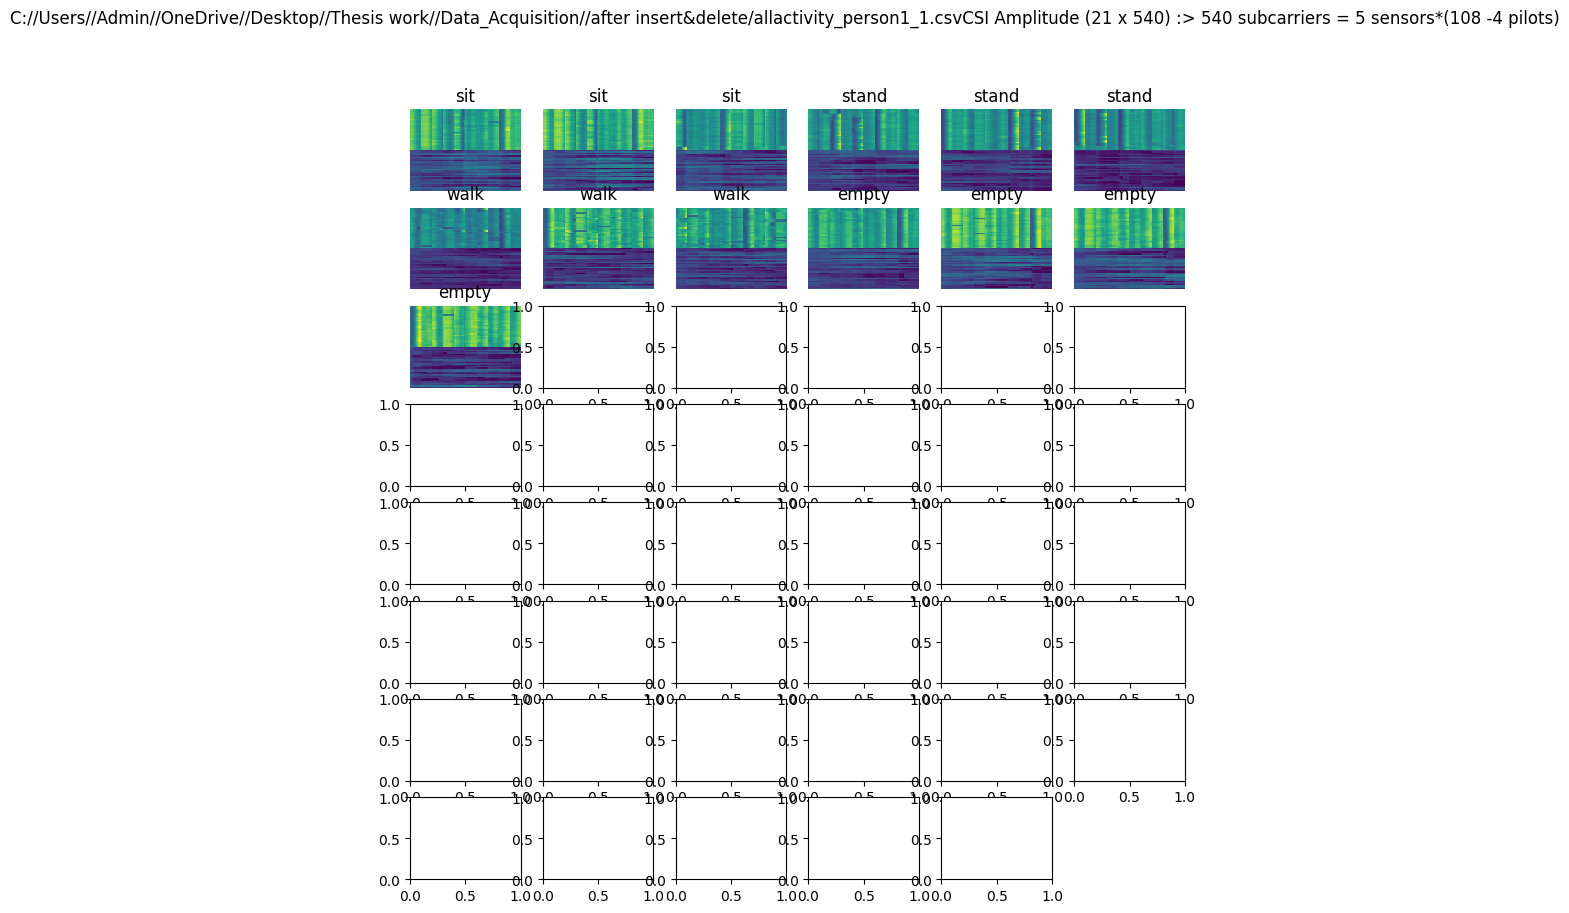

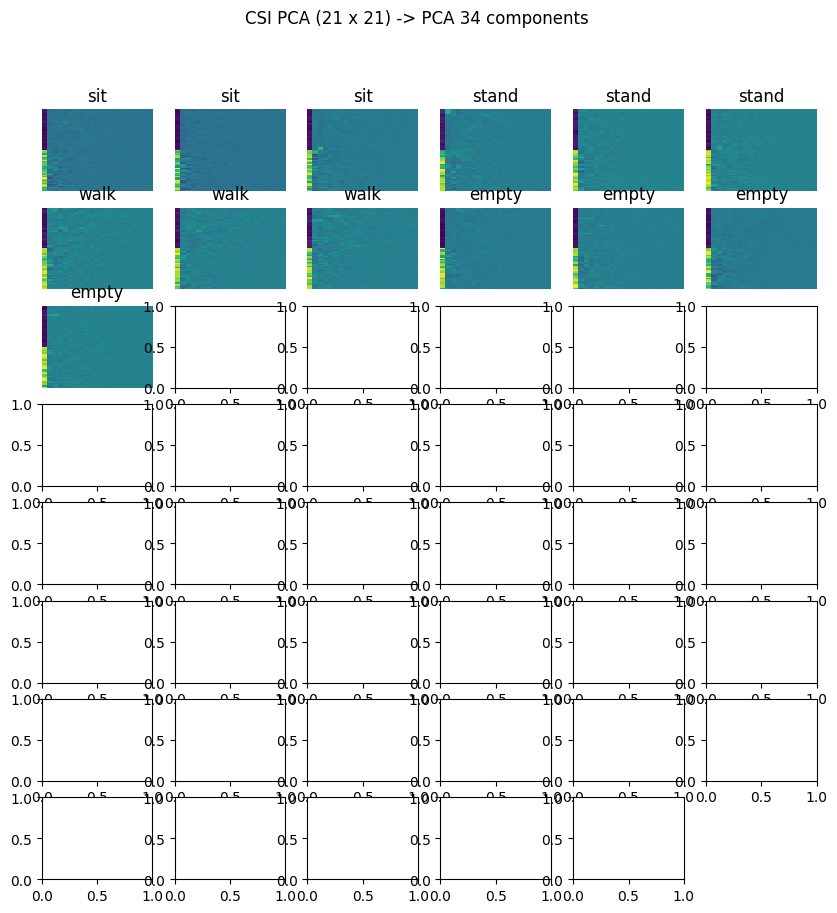

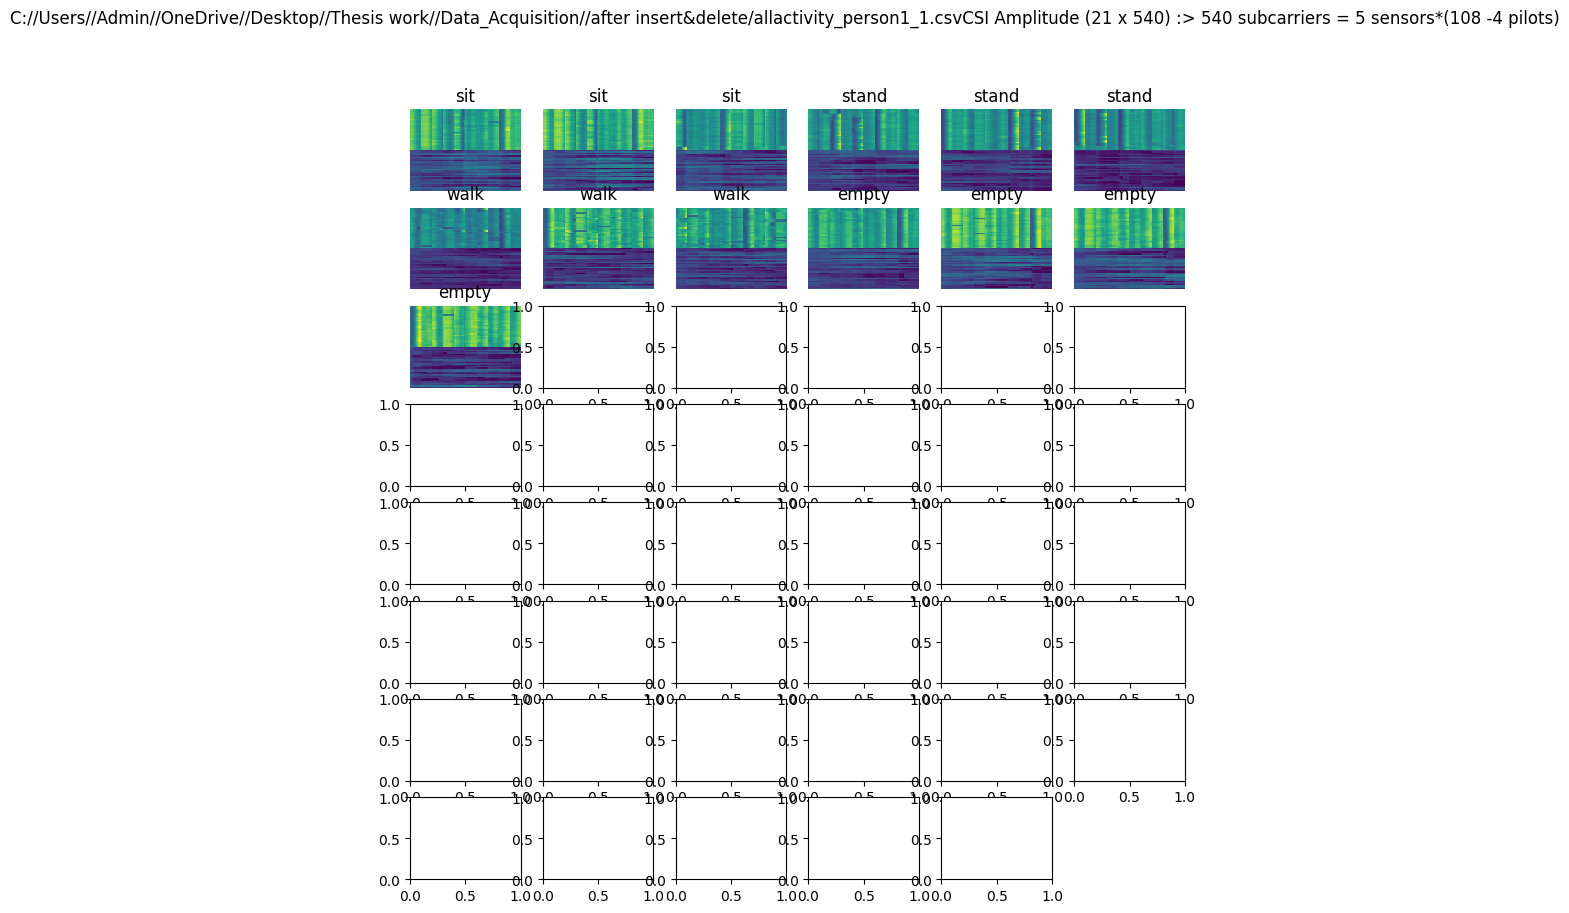

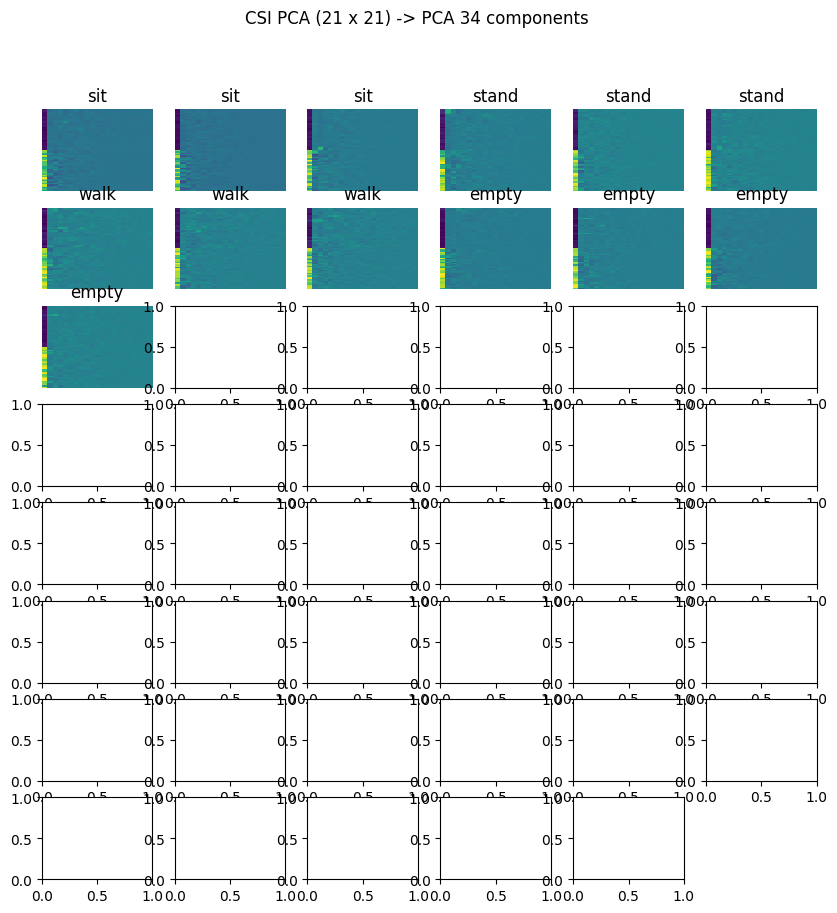

In [22]:
###############################################
# Loop X-Domain CSI Images
###############################################
wEmptyFrames = False

models=['m1','m2','m3']
#runs = ['run1','run2','run3']
#bundles = ['6','43','121','321','332','432']
bundles = ['6','43','321']
test_envs=['4e','ITIV']  

#'6':  m1 for i in range(0,6):            # g1 = S3  S9  S11 S12 S13 S15 
#'43': m1 for i in range(2,6):            # g1 = S11 S12 S13 S15 
#      m2 for i in range(0,3):            # g1 = S3  S9  S11 
#'321' m1 for i in range(3,NS):           # g1 = S12 S13 S15
#      m2 for i in range(1,3):            # g1 = S9 S11
#      m3     i = 0;                      # g1 = S3 

for test_env in test_envs: 
    for bundle in bundles:
        
        if bundle == '321': models=['m1','m2','m3']; tmodels='m1m2m3 = (S12.S13.S15)(S9.S11)(S3)'
        if bundle == '43': models=['m1','m2']; tmodels='m1m2 = (S11.S12.S13.S15)(S3.S9.S11)'
        if bundle == '6': models=['m1']; tmodels='m1 = (S3.S9.S11.S13.S15.S16)'
 
        fig, axs = plt.subplots(2,6)
        fig.set_figwidth(12)
        fig.set_figheight(4)
        fig.suptitle('S261 B'+bundle+' '+tmodels+' Env: '+test_env)
        
        for i in range(2):
            for j in range(6):
                axs[i,j].axis('off')
 
        for mod in models:
            trainx, trainy, imgI, imgR, ab, abPCA = read_csiKIT(trainD=True,wPCA=True, showIm =True,Niter=1,wFilter=False,oAbs=False)
            trainx = np.expand_dims(trainx, axis=1)
            
            if mod == 'm1':
                axs[0,0].imshow(imgI, interpolation='nearest',aspect='auto')
                axs[0,0].title.set_text(mod+' Im('+str(imgI.shape[0])+','+str(imgI.shape[1])+')')
                axs[0,1].imshow(imgR, interpolation='nearest',aspect='auto')
                axs[0,1].title.set_text(mod+' Re('+str(imgI.shape[0])+','+str(imgI.shape[1])+')')

                axs[1,0].imshow(ab, interpolation='nearest',aspect='auto')
                axs[1,0].title.set_text('Abs_Pha('+str(ab.shape[0])+','+str(ab.shape[1])+')')
                axs[1,1].imshow(abPCA, interpolation='nearest',aspect='auto')
                axs[1,1].title.set_text('PCA(24,24)')
            
            if mod == 'm2':
                axs[0,2].imshow(imgI, interpolation='nearest',aspect='auto')
                axs[0,2].title.set_text(mod+' Im('+str(imgI.shape[0])+','+str(imgI.shape[1])+')')
                axs[0,3].imshow(imgR, interpolation='nearest',aspect='auto')
                axs[0,3].title.set_text(mod+' Re('+str(imgI.shape[0])+','+str(imgI.shape[1])+')')

                axs[1,2].imshow(ab, interpolation='nearest',aspect='auto')
                axs[1,2].title.set_text('Abs_Pha('+str(ab.shape[0])+','+str(ab.shape[1])+')')
                axs[1,3].imshow(abPCA, interpolation='nearest',aspect='auto')
                axs[1,3].title.set_text('PCA(24,24')
            if mod == 'm3':
                axs[0,4].imshow(imgI, interpolation='nearest',aspect='auto')
                axs[0,4].title.set_text(mod+' Re('+str(imgI.shape[0])+','+str(imgI.shape[1])+')')
                axs[0,5].imshow(imgR, interpolation='nearest',aspect='auto')
                axs[0,5].title.set_text(mod+' Re('+str(imgI.shape[0])+','+str(imgI.shape[1])+')')

                axs[1,4].imshow(ab, interpolation='nearest',aspect='auto')
                axs[1,4].title.set_text('Abs_Pha('+str(ab.shape[0])+','+str(ab.shape[1])+')')
                axs[1,5].imshow(abPCA, interpolation='nearest',aspect='auto')
                axs[1,5].title.set_text('PCA(24,24)')